In [1]:
# %matplotlib widget
from core.data import *
import numpy as np
import numpy as np
from core.util.myPCA import myPCA
from core.util.myKMeans import myKMeans
from core.util import Shrink, invShrink
import matplotlib.pyplot as plt
from core.util.color_space import *
import copy
import warnings
warnings.filterwarnings("ignore")

verbose=True


In [2]:
It = load(Rtype='test', ct=-1, size=[256])
I = load(Rtype='train', ct=-1, size=[256])

I[0].shape, It[0].shape
I, It = I[0].astype('float64'),It[0].astype('float64')
np.max(It[0]), np.min(It[0])

(254.0, 10.0)

In [3]:
class Evl_color():
    def energy_ratio(tX):
        ratio = []
        s  = []
        for i in range(len(tX)):
            t = tX[i].reshape(-1, tX.shape[-1]).astype('float64')
            t = np.mean(np.square(t), axis=0)
            s.append(np.sum(t))
            t = t/np.sum(t)
            ratio.append(t)
        ratio = np.array(ratio)
        plt.hist(s)
        plt.show()
        for i in range(ratio.shape[1]):
            plt.hist(ratio[:,i], bins=32)
            plt.title('Channel#'+str(i))
            plt.show()
        return ratio, s
    def eng(X):
        a = X.reshape(-1,X.shape[-1])
        return sorted(np.mean(np.square(a),axis=0), key=lambda x:-x)
        
        
class PQR:
    def __init__(self, win=32):
        self.win = win
        self.myPCA_list = []
        self.colorM = myKMeans(256)

    def rep(self, blabel):
        for i in range(int(np.log2(self.win**2))):
            blabel = np.concatenate([blabel, blabel], axis=-1)
        blabel = invShrink(blabel, self.win)
        return blabel
    
    def get_mean(self, X):
        a = Shrink(X[:,:,:,:1], self.win)
        S = a.shape
        a = a.reshape(-1, a.shape[-1])
        m1 = np.mean(a, axis=-1, keepdims=True)  
        a = Shrink(X[:,:,:,1:2], self.win)
        a = a.reshape(-1, a.shape[-1])
        m2 = np.mean(a, axis=-1, keepdims=True) 
        a = Shrink(X[:,:,:,2:], self.win)
        a = a.reshape(-1, a.shape[-1])
        m3 = np.mean(a, axis=-1, keepdims=True) 
        return np.concatenate([m1,m2,m3],axis=1).reshape(S[0],S[1],S[2],-1)
    def remove_mean(self, X, m):
        a = Shrink(X[:,:,:,:1], self.win)
        a = invShrink(a-m[:,:,:,:1], self.win)
        b = Shrink(X[:,:,:,1:2], self.win)
        b = invShrink(b-m[:,:,:,1:2], self.win)
        c = Shrink(X[:,:,:,2:], self.win)
        c = invShrink(c-m[:,:,:,2:], self.win)
        return np.concatenate([a,b,c],axis=-1)
    def add_mean(self, X, m):
        a = Shrink(X[:,:,:,:1], self.win)
        a = invShrink(a+m[:,:,:,:1], self.win)
        b = Shrink(X[:,:,:,1:2], self.win)
        b = invShrink(b+m[:,:,:,1:2], self.win)
        c = Shrink(X[:,:,:,2:], self.win)
        c = invShrink(c+m[:,:,:,2:], self.win)
        return np.concatenate([a,b,c],axis=-1)
    
    def fit(self, tX):
        X = tX.copy()
        mX = self.get_mean(X)
        self.mX = mX
        self.colorM.fit(mX)
        label = self.colorM.predict(mX)
        blabel = label.reshape(X.shape[0],X.shape[1]//self.win,X.shape[2]//self.win,1)
        blabel = self.rep(blabel)
        imX = self.colorM.inverse_predict(label)   
        print('PQR ',self.win,np.mean(np.square(mX-imX)))   
        X = self.remove_mean(X, imX)
        X = X.reshape(-1, X.shape[-1])
        for i in range(256):
            idx = blabel.reshape(-1) == i
            self.myPCA_list.append(myPCA(-1).fit(X[idx]))
        return self

    def transform(self, tX):
        X = tX.copy()
        print('eng init',Evl_color.eng(X))   
        mX = self.get_mean(X)
        label = self.colorM.predict(mX)
        blabel = label.reshape(X.shape[0],X.shape[1]//self.win,X.shape[2]//self.win,1)
        blabel = self.rep(blabel)
        imX = self.colorM.inverse_predict(label) 
        print('PQR ',self.win,np.mean(np.square(mX-imX)))   
        X = self.remove_mean(X, imX)
        
        print('eng remove mean',Evl_color.eng(X)) 
        S = X.shape
        X = X.reshape(-1, X.shape[-1])
        tX = np.zeros_like(X)
        for i in range(256):
            idx = blabel.reshape(-1) == i
            if np.sum(idx) < 1:
                continue
            tX[idx] = self.myPCA_list[i].transform(X[idx])
        print('eng transform',Evl_color.eng(tX))
        return label, tX.reshape(S)
    
    def transform1(self, tX):
        X = tX.copy()
        print('eng init',Evl_color.eng(X))   
        mX = self.get_mean(X)
        label = self.colorM.predict(mX)
        blabel = label.reshape(X.shape[0],X.shape[1]//self.win,X.shape[2]//self.win,1)
        blabel = self.rep(blabel)
        imX = self.colorM.inverse_predict(label) 
        print('PQR ',self.win,np.mean(np.square(mX-imX)))   
        X = self.remove_mean(X, mX)
        print('eng remove mean',Evl_color.eng(X)) 
        S = X.shape
        X = X.reshape(-1, X.shape[-1])
        tX = np.zeros_like(X)
        for i in range(256):
            idx = blabel.reshape(-1) == i
            if np.sum(idx) < 1:
                continue
            tX[idx] = self.myPCA_list[i].transform(X[idx])
        print('eng transform',Evl_color.eng(tX))
        return mX, tX.reshape(S)
    
    def inverse_transform(self, label, tX):
        S = tX.shape
        tX = tX.reshape(-1, tX.shape[-1])
        X = np.zeros_like(tX)
        blabel = label.reshape(S[0],S[1]//self.win,S[2]//self.win,1)
        blabel = self.rep(label)
        for i in range(256):
            idx = blabel.reshape(-1) == i
            if np.sum(idx) < 1:
                continue
            X[idx] = self.myPCA_list[i].inverse_transform(tX[idx])
        imX = self.colorM.inverse_predict(label)   
        X = self.add_mean(X.reshape(S), imX)
        return X
    
    def inverse_transform1(self, mx, tX):
        S = tX.shape
        tX = tX.reshape(-1, tX.shape[-1])
        X = np.zeros_like(tX)
        label = self.colorM.predict(mx)
        blabel = label.reshape(S[0],S[1]//self.win,S[2]//self.win,1)
        blabel = self.rep(label)
        for i in range(256):
            idx = blabel.reshape(-1) == i
            if np.sum(idx) < 1:
                continue
            X[idx] = self.myPCA_list[i].inverse_transform(tX[idx])
        X = self.add_mean(X.reshape(S), mx)
        return X


In [4]:
pqr32 = PQR(32).fit(I)
pqr256 = PQR(256).fit(I)

PQR  32 31.10927392772441


WARNING clustering 1427 points to 256 centroids: please provide at least 9984 training points


PQR  256 16.30215918562344


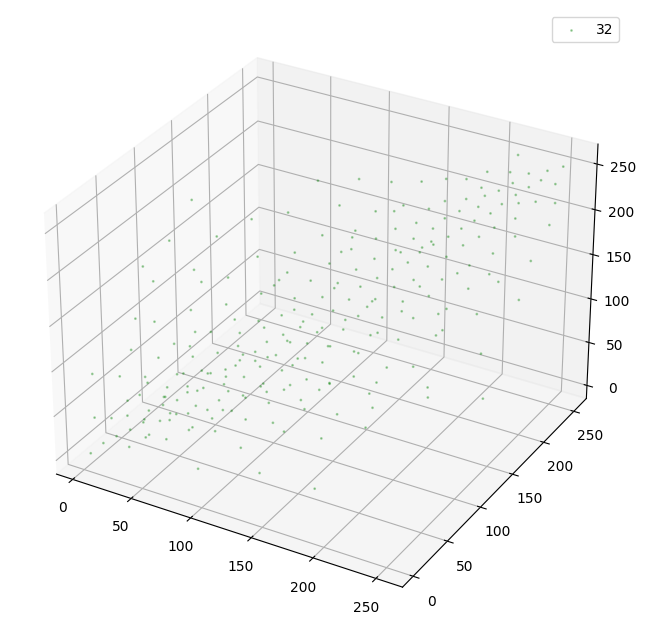

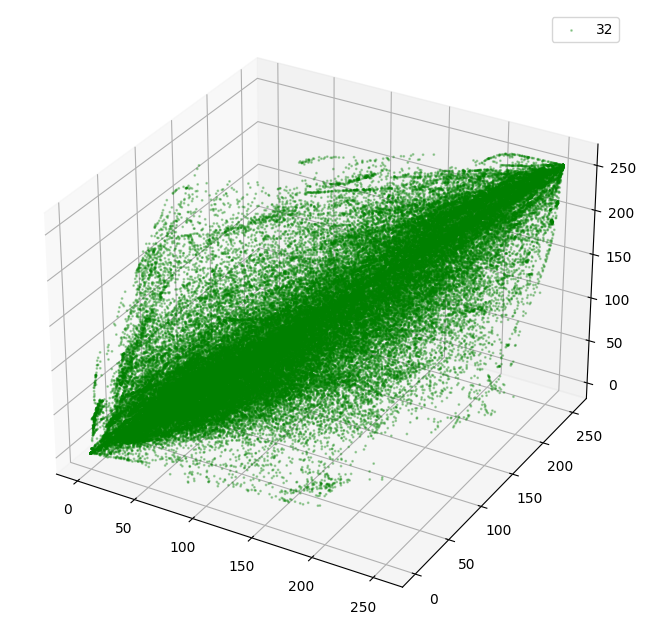

In [24]:

fig = plt.figure(figsize = (12, 8))
ax = plt.axes(projection ="3d")
mX32, mX256 = pqr32.colorM.inverse_predict(np.arange(256).reshape(-1,1)).reshape(-1,3), pqr256.mX.reshape(-1,3)
ax.scatter3D(mX32[:,0],mX32[:,1], mX32[:,2], color = "green",label='32',alpha=0.3,s=1)
#ax.scatter3D(mX256[:,0],mX256[:,1], mX256[:,2], color = "blue",label='256',alpha=0.3,s=1)
plt.legend()
plt.show()

fig = plt.figure(figsize = (12, 8))
ax = plt.axes(projection ="3d")
mX32, mX256 = pqr32.mX.reshape(-1,3), pqr256.mX.reshape(-1,3)
ax.scatter3D(mX32[:,0],mX32[:,1], mX32[:,2], color = "green",label='32',alpha=0.3,s=1)
#ax.scatter3D(mX256[:,0],mX256[:,1], mX256[:,2], color = "blue",label='256',alpha=0.3,s=1)
plt.legend()
plt.show()

In [19]:
if 1==1:
    c, d = transform(pqr32, It)
    iIt1 = pqr32.inverse_transform(c,d)
    print(np.mean(np.square(It-iIt1)))
    print(len(np.unique(c)))

eng init [22413.597091920914, 20020.83438258017, 18955.633553043488]
PQR  32 46.93794224841193
eng remove mean [1617.5818423615988, 1352.5252541181862, 1318.3799173319212]
0.0
0.16808948971375876
eng transform [3780.4786756847957, 392.1672286348887, 115.84110947164615]
0.16808948971375876
2.595438805361973e-28
245


In [6]:
for i in range(len(It)):
    label, tX = pqr32.transform(It[i:i+1])
    m, tX1 = pqr256.transform(It[i:i+1])  
    print('------------------')

eng init [26975.189727783203, 23853.628189086914, 21245.394607543945]
PQR  32 18.217011253039043
eng remove mean [1560.7833938598633, 1244.5202102661133, 1215.6927871704102]
eng transform [3905.5092283705094, 94.8622556635948, 20.62490726219845]
eng init [26975.189727783203, 23853.628189086914, 21245.394607543945]
PQR  256 6.6571304194318754
eng remove mean [3582.284492492676, 2309.778980255127, 2176.9476928710938]
eng transform [7688.47430574524, 372.837574925044, 7.699284948366576]
------------------
eng init [30454.16487121582, 23634.417022705078, 18919.33673095703]
PQR  32 24.942465032140415
eng remove mean [1220.5879650115967, 975.9650211334229, 933.4872512817383]
eng transform [2945.8292812196746, 164.14168179275762, 20.069274414375574]
eng init [30454.16487121582, 23634.417022705078, 18919.33673095703]
PQR  256 31.33422054979019
eng remove mean [2825.1826515197754, 1989.5818939208984, 1879.3905639648438]
eng transform [5986.409616323356, 670.8620263207672, 36.88346676142488]
---

eng transform [2328.2171253006372, 122.00557186158404, 47.46158144514904]
eng init [4860.067001342773, 3870.250930786133, 3529.9935302734375]
PQR  256 34.460393108893186
eng remove mean [2490.2107105255127, 2111.1116313934326, 2086.3531131744385]
eng transform [6358.459597312175, 222.57374515647572, 106.64211262481388]
------------------
eng init [6854.808486938477, 5689.957702636719, 5364.832473754883]
PQR  32 25.111384510993958
eng remove mean [1450.8856122493744, 1435.089007616043, 1371.039700448513]
eng transform [3918.6622303917857, 261.6550990654264, 76.69699085674321]
eng init [6854.808486938477, 5689.957702636719, 5364.832473754883]
PQR  256 9.05568571590508
eng remove mean [2995.529670715332, 2883.3372192382812, 2726.284613609314]
eng transform [8143.524494655464, 338.24247430848743, 123.38453459891839]
------------------
eng init [3731.1700439453125, 3190.1708984375, 2965.792251586914]
PQR  32 16.31240097184976
eng remove mean [1067.1411259174347, 971.5881756544113, 966.07778

eng transform [3128.955002672332, 165.95470442937994, 66.10988995181734]
eng init [29402.852249145508, 23604.358932495117, 14361.047592163086]
PQR  256 52.461706464722134
eng remove mean [3854.0916385650635, 3698.127109527588, 3385.3029251098633]
eng transform [10255.935369505307, 542.5673880767008, 139.01891562041052]
------------------
eng init [36750.50761413574, 28936.754501342773, 24006.259201049805]
PQR  32 53.265554919838905
eng remove mean [1279.9528560638428, 1139.6832466125488, 1059.040244102478]
eng transform [2949.450598119982, 464.964499846062, 64.26124881278737]
eng init [36750.50761413574, 28936.754501342773, 24006.259201049805]
PQR  256 3.7110611227496215
eng remove mean [6566.2883377075195, 4023.354747772217, 2798.281223297119]
eng transform [10039.525012830021, 3264.273242694495, 84.12605325241141]
------------------
eng init [35606.5950012207, 28569.597732543945, 24286.796600341797]
PQR  32 50.348971163233124
eng remove mean [1840.7782621383667, 1480.97177028656, 138

eng transform [10502.181788297845, 247.07295118187275, 173.9835303274983]
------------------
eng init [18884.55290222168, 16756.15202331543, 16177.904678344727]
PQR  32 69.65173016488552
eng remove mean [3249.961961746216, 1306.783911705017, 1150.2781419754028]
eng transform [3803.899315980758, 1610.8057619446136, 292.31893750125994]
eng init [18884.55290222168, 16756.15202331543, 16177.904678344727]
PQR  256 3.9485938594831773
eng remove mean [6281.224388122559, 3205.1470527648926, 2873.9125423431396]
eng transform [8721.606715594136, 2970.4937742384645, 668.18349339806]
------------------
eng init [37917.443618774414, 27218.286346435547, 18241.915634155273]
PQR  32 51.80051534374555
eng remove mean [1108.4658031463623, 706.4065761566162, 480.38158798217773]
eng transform [1889.1005143379057, 361.02480352172023, 45.12864942554626]
eng init [37917.443618774414, 27218.286346435547, 18241.915634155273]
PQR  256 5.212199885242929
eng remove mean [3783.436113357544, 1515.070182800293, 790.

eng transform [1032.0904826097521, 84.68227211309794, 84.19789499638267]
eng init [50006.33264160156, 36916.50129699707, 29743.79100036621]
PQR  256 67.59066711661096
eng remove mean [1572.7618217468262, 1141.8772430419922, 653.3516845703125]
eng transform [3000.8107677085677, 264.9744611539889, 102.2055204966015]
------------------
eng init [38197.34590148926, 37639.640060424805, 37023.30520629883]
PQR  32 11.311611145734787
eng remove mean [1535.800850868225, 1313.3726272583008, 1300.3256125450134]
eng transform [4078.76179334501, 56.88246509494091, 13.854832231625416]
eng init [38197.34590148926, 37639.640060424805, 37023.30520629883]
PQR  256 5.995717209298164
eng remove mean [7894.440418243408, 7549.322052001953, 6896.766189575195]
eng transform [22159.81251983673, 162.7874607185302, 17.9286792646844]
------------------
eng init [14247.097869873047, 13268.95002746582, 12915.204467773438]
PQR  32 14.953810329238573
eng remove mean [1926.0785942077637, 1655.277642250061, 1650.370881

eng transform [4994.616594966603, 918.0636227579746, 220.04016878053488]
------------------
eng init [9385.384704589844, 5571.85758972168, 5524.413726806641]
PQR  32 66.10592002173264
eng remove mean [1648.5621938705444, 1575.1911046504974, 1074.2058458328247]
eng transform [3273.056208521098, 820.2811455102903, 204.62179032250484]
eng init [9385.384704589844, 5571.85758972168, 5524.413726806641]
PQR  256 48.1586984496098
eng remove mean [2617.4713020324707, 2527.6659240722656, 2431.7290000915527]
eng transform [5937.012733884575, 1289.2799243261716, 350.57356798560943]
------------------
eng init [18814.6416015625, 18319.389266967773, 18257.889114379883]
PQR  32 32.87467108170191
eng remove mean [1481.2865676879883, 1423.1751642227173, 1418.883056640625]
eng transform [4004.7269487933204, 267.6024307486623, 51.0154090092617]
eng init [18814.6416015625, 18319.389266967773, 18257.889114379883]
PQR  256 3.2531727656411626
eng remove mean [5932.314102172852, 5507.11421585083, 4379.0068130

eng transform [3577.3687435601096, 487.8965843764508, 69.46805619583887]
eng init [12928.036026000977, 7453.0477294921875, 6250.548599243164]
PQR  256 50.03339122623826
eng remove mean [2077.0501804351807, 1774.962272644043, 1578.161148071289]
eng transform [4845.295436429779, 442.16436762188937, 142.71379709873017]
------------------
eng init [37858.28366088867, 36840.3359375, 34493.564682006836]
PQR  32 21.875780418515205
eng remove mean [2489.5776138305664, 2395.8475646972656, 2388.6157608032227]
eng transform [7106.416916611904, 116.53727396958685, 51.086748749082176]
eng init [37858.28366088867, 36840.3359375, 34493.564682006836]
PQR  256 23.671408218098804
eng remove mean [4283.582664489746, 4275.41291809082, 4164.5799560546875]
eng transform [12526.011514429336, 146.57422133520447, 50.98980287079864]
------------------
eng init [35847.0623626709, 34896.10209655762, 32823.10134887695]
PQR  32 22.486962368090946
eng remove mean [3037.8150148391724, 2808.041456222534, 2737.16781806

eng transform [2288.764400460432, 142.89453746518788, 43.0621919686004]
eng init [12345.782989501953, 10816.451263427734, 5039.348007202148]
PQR  256 17.681036021948483
eng remove mean [2428.771755218506, 2410.516777038574, 1857.3616609573364]
eng transform [6073.871076068974, 594.7874456918607, 27.99167145404202]
------------------
eng init [10070.357467651367, 8291.697204589844, 2548.2613067626953]
PQR  32 35.93843008081118
eng remove mean [975.4033803939819, 895.4741630554199, 383.41517162323]
eng transform [2082.2772241855105, 136.30525041510546, 35.7102404720004]
eng init [10070.357467651367, 8291.697204589844, 2548.2613067626953]
PQR  256 21.530143200575065
eng remove mean [1610.1566925048828, 1450.6594047546387, 402.3440580368042]
eng transform [2971.446935775261, 419.62004447760387, 72.09317504356831]
------------------
eng init [41698.30924987793, 18711.91893005371, 11587.397918701172]
PQR  32 269.1569874882698
eng remove mean [1506.433256149292, 915.5174808502197, 797.4209918

eng transform [6602.277382132643, 90.105573272627, 9.849191811516297]
eng init [12447.322967529297, 11769.902954101562, 11238.640167236328]
PQR  256 5.459442358153562
eng remove mean [3865.1755981445312, 3684.215633392334, 3579.130584716797]
eng transform [10997.620316001772, 123.34540932166168, 7.556090928843855]
------------------
eng init [30778.139114379883, 27507.682495117188, 24633.25375366211]
PQR  32 23.214077040553093
eng remove mean [1128.549488067627, 1004.836049079895, 903.0300941467285]
eng transform [2784.11370631127, 221.02485653469546, 31.277068448212315]
eng init [30778.139114379883, 27507.682495117188, 24633.25375366211]
PQR  256 5.36132922093384
eng remove mean [6400.137557983398, 4551.514587402344, 2579.3520736694336]
eng transform [11952.643361223158, 1553.2258638600463, 25.134993971951243]
------------------
eng init [30768.422592163086, 27725.66586303711, 24739.536697387695]
PQR  32 22.882401784261067
eng remove mean [865.6610794067383, 840.7992057800293, 831.671

eng transform [6762.0381265604165, 214.04485784794642, 81.86237768270827]
eng init [24068.872619628906, 19501.876251220703, 14393.900787353516]
PQR  256 12.214033838982383
eng remove mean [5317.847434997559, 5215.359283447266, 3886.729232788086]
eng transform [13963.11462208959, 367.4230815635417, 89.39824757979625]
------------------
eng init [27945.059310913086, 23656.145233154297, 16706.311248779297]
PQR  32 34.56828661262989
eng remove mean [2544.67999458313, 2272.045247077942, 1556.2807884216309]
eng transform [6022.344223280597, 210.74253094612243, 139.91927585588581]
eng init [27945.059310913086, 23656.145233154297, 16706.311248779297]
PQR  256 10.488416665621722
eng remove mean [4854.50496673584, 4649.495758056641, 3327.7701873779297]
eng transform [12194.92216112181, 425.59780517209884, 211.25094587676332]
------------------
eng init [50934.735610961914, 41505.962158203125, 30850.137649536133]
PQR  32 29.287911315759022
eng remove mean [2420.3000230789185, 1826.3982963562012, 

In [28]:
a = [[[26975.189727783203, 23853.628189086914, 21245.394607543945],18.217011253039043,[1560.7833938598633, 1244.5202102661133, 1215.6927871704102],[3905.5092283705094, 94.8622556635948, 20.62490726219845],[26975.189727783203, 23853.628189086914, 21245.394607543945],6.6571304194318754,[3582.284492492676, 2309.778980255127, 2176.9476928710938],[7688.47430574524, 372.837574925044, 7.699284948366576]],[[30454.16487121582, 23634.417022705078, 18919.33673095703],24.942465032140415,[1220.5879650115967, 975.9650211334229, 933.4872512817383],[2945.8292812196746, 164.14168179275762, 20.069274414375574],[30454.16487121582, 23634.417022705078, 18919.33673095703],31.33422054979019,[2825.1826515197754, 1989.5818939208984, 1879.3905639648438],[5986.409616323356, 670.8620263207672, 36.88346676142488]],[[11309.879409790039, 10895.880447387695, 9162.319122314453],25.968144009510677,[1092.1249647140503, 1081.1699895858765, 1052.5762405395508],[2971.9396263214885, 198.8800173628624, 55.05155115513421],[11309.879409790039, 10895.880447387695, 9162.319122314453],5.070025315042585,[2102.490089416504, 1989.6789112091064, 1948.9718933105469],[5608.583536992617, 354.72517428088884, 77.83218266260965]],[[26241.012969970703, 23779.66371154785, 21994.190704345703],18.11099415520827,[888.0909667015076, 778.8744840621948, 735.2146511077881],[2244.597703136198, 144.8836498209694, 12.698748914321778],[26241.012969970703, 23779.66371154785, 21994.190704345703],6.858764364772166,[3871.8289184570312, 2964.096221923828, 1799.324966430664],[8172.795268679988, 426.7624724828316, 35.69236564875167]],[[21909.507278442383, 18649.48211669922, 16438.686264038086],20.10411537686984,[1617.1304087638855, 1594.6589050292969, 1564.3085203170776],[4490.242463508733, 262.98790747738866, 22.867463124236586],[21909.507278442383, 18649.48211669922, 16438.686264038086],2.913540071963022,[4338.376224517822, 3842.727550506592, 3050.31640625],[10594.765538672022, 625.9591755827532, 10.695467020057507]],[[25580.22996520996, 23097.238342285156, 20860.56707763672],13.419166758656502,[1233.9923071861267, 1110.5411338806152, 1034.3466811180115],[3188.2916128893758, 179.19875065831476, 11.389758637220183],[25580.22996520996, 23097.238342285156, 20860.56707763672],7.194842104877655,[3709.0044288635254, 3421.106475830078, 3031.1560974121094],[9864.413227503484, 269.16775911536183, 27.68601548712601]],[[25232.994720458984, 22336.682876586914, 20913.000045776367],15.976876984039942,[226.3218994140625, 150.85209465026855, 141.2693634033203],[455.57303526120995, 51.080494692878204, 11.789827513564083],[25232.994720458984, 22336.682876586914, 20913.000045776367],24.886779353177797,[476.91341400146484, 436.96998596191406, 319.5164451599121],[1072.8276571347792, 153.3290707307422, 7.243117257744933]],[[17983.277877807617, 17926.315719604492, 17527.623764038086],18.847517525156338,[1327.010980606079, 978.0006518363953, 871.4419264793396],[3017.0076808246176, 126.80500428267823, 32.640873814538246],[17983.277877807617, 17926.315719604492, 17527.623764038086],11.954814543559527,[2211.4841175079346, 2162.7356719970703, 1791.5237350463867],[5803.434421627287, 297.136644748471, 65.17245817573144]],[[16002.357437133789, 15713.049240112305, 12534.903732299805],26.871239746610325,[1775.014347076416, 1131.3812141418457, 1038.071970462799],[3672.8252706941066, 191.94956687476343, 79.69269411217503],[16002.357437133789, 15713.049240112305, 12534.903732299805],28.08629577071406,[2900.818223953247, 2292.4605026245117, 2103.9398880004883],[6710.060161828108, 447.67685115021237, 139.48160159995055]],[[26246.864974975586, 25410.296966552734, 17206.042846679688],84.3084131727616,[3011.713014602661, 2664.0202531814575, 2534.035478115082],[7578.287781682931, 411.3285344216485, 220.1524297946213],[26246.864974975586, 25410.296966552734, 17206.042846679688],15.516307347531741,[5379.8659019470215, 5103.714866638184, 4391.857177734375],[12757.227323666782, 1337.9793427087056, 780.2312799436753]],[[23631.513565063477, 17722.655364990234, 13827.12141418457],62.13085666298866,[5620.944892883301, 4728.378386974335, 4037.1384420394897],[13466.272884835571, 729.2882733858527, 190.90056367543616],[23631.513565063477, 17722.655364990234, 13827.12141418457],18.57816332532093,[7822.227504730225, 5931.123382568359, 5378.384870529175],[16413.210195219828, 2420.428819865022, 298.0967427434997]],[[27684.5672454834, 26280.63623046875, 21468.093292236328],21.60843936105569,[1627.0895462036133, 1541.8032212257385, 1465.7456846237183],[4418.399752374299, 152.12007107688652, 64.11862860184165],[27684.5672454834, 26280.63623046875, 21468.093292236328],19.086912990004446,[5597.3379554748535, 3954.993865966797, 3393.6851348876953],[12368.98068027802, 520.1100544668902, 56.926221584322185]],[[26246.436813354492, 24483.160263061523, 21584.25260925293],20.02860316137473,[1754.8442430496216, 1424.9299640655518, 1410.7451829910278],[4295.831188744068, 247.6772939748316, 47.01090738730074],[26246.436813354492, 24483.160263061523, 21584.25260925293],4.2922367753926665,[7313.1201095581055, 5512.878093719482, 4050.1924934387207],[15646.794286720351, 1161.244203830068, 68.15220616630246]],[[15180.460861206055, 15068.626815795898, 12858.743072509766],26.58614941438039,[907.2213258743286, 850.2892684936523, 838.9870891571045],[2417.174269092474, 133.73393232101822, 45.58948211162777],[15180.460861206055, 15068.626815795898, 12858.743072509766],17.393186908060063,[3122.8045196533203, 2710.3258533477783, 2599.334571838379],[7960.287947816011, 403.9911709304482, 68.1858260930884]],[[22824.196716308594, 21734.915161132812, 17878.5125579834],28.416415388385456,[2410.7112045288086, 2028.9133205413818, 1944.1418528556824],[6044.07521059417, 255.83624220735106, 83.8549251244274],[22824.196716308594, 21734.915161132812, 17878.5125579834],13.535847531088317,[4051.832717895508, 3911.4507904052734, 3747.862777709961],[10958.062843470461, 597.3781679557962, 155.70527458449774]],[[22462.28890991211, 17706.596069335938, 14616.575759887695],26.105255698164303,[2376.654963493347, 1568.7632932662964, 1450.759686946869],[5007.266974395757, 328.51154050156975, 60.399428809174495],[22462.28890991211, 17706.596069335938, 14616.575759887695],4.74852431138667,[4581.54052734375, 4531.611484527588, 3901.4763259887695],[11657.339004016927, 1290.0921547950472, 67.19717904822222]],[[24167.95751953125, 20567.37564086914, 14929.4248046875],31.617040793100994,[2144.766357421875, 1548.6877040863037, 1417.7227582931519],[4784.714469167184, 247.4328270077431, 79.0295236263657],[24167.95751953125, 20567.37564086914, 14929.4248046875],17.5776828682671,[3353.775100708008, 2573.8934326171875, 2228.664794921875],[7708.546747092721, 338.42756464715785, 109.3590165071901]],[[20698.35482788086, 14686.146743774414, 10044.528915405273],27.72714126110077,[2123.2928714752197, 1213.3638591766357, 1013.9245443344116],[4035.2227531152403, 255.16035539126526, 60.1981664797393],[20698.35482788086, 14686.146743774414, 10044.528915405273],3.9235484350162246,[3264.050262451172, 1898.1740417480469, 1788.2136363983154],[6240.000348836686, 630.9465969278682, 79.49099483297152]],[[4860.067001342773, 3870.250930786133, 3529.9935302734375],16.6824412047863,[852.0986902713776, 844.1322991847992, 801.4532891511917],[2328.2171253006372, 122.00557186158404, 47.46158144514904],[4860.067001342773, 3870.250930786133, 3529.9935302734375],34.460393108893186,[2490.2107105255127, 2111.1116313934326, 2086.3531131744385],[6358.459597312175, 222.57374515647572, 106.64211262481388]],[[6854.808486938477, 5689.957702636719, 5364.832473754883],25.111384510993958,[1450.8856122493744, 1435.089007616043, 1371.039700448513],[3918.6622303917857, 261.6550990654264, 76.69699085674321],[6854.808486938477, 5689.957702636719, 5364.832473754883],9.05568571590508,[2995.529670715332, 2883.3372192382812, 2726.284613609314],[8143.524494655464, 338.24247430848743, 123.38453459891839]],[[3731.1700439453125, 3190.1708984375, 2965.792251586914],16.31240097184976,[1067.1411259174347, 971.5881756544113, 966.0777839422226],[2789.8845918744137, 160.65969094461212, 54.26280269503677],[3731.1700439453125, 3190.1708984375, 2965.792251586914],27.862581617586937,[2103.8509941101074, 2024.1138343811035, 1908.8138875961304],[5664.582889475086, 277.9594371043809, 94.2363895078025]],[[16718.886657714844, 13400.725112915039, 11100.401718139648],21.867465029160183,[1863.635235786438, 838.8813300132751, 724.0303010940552],[2986.226795236757, 383.9170041603166, 56.403067496694064],[16718.886657714844, 13400.725112915039, 11100.401718139648],10.565871145110577,[3612.7161712646484, 1768.4146842956543, 1570.3307266235352],[6194.081572108906, 639.2358196640787, 118.14419041090953]],[[29502.233367919922, 14988.334365844727, 11214.887008666992],251.94895377755165,[2214.9927382469177, 1103.807466506958, 1052.6801257133484],[2801.030107216232, 1272.3224091096995, 298.1278141412722],[29502.233367919922, 14988.334365844727, 11214.887008666992],54.51991293563818,[4576.844497680664, 3388.169141769409, 2186.220146179199],[5929.009979364919, 4134.253368436681, 87.9704378274825]],[[25811.77456665039, 25773.226348876953, 25112.920776367188],23.90639250477155,[1264.7920894622803, 1199.260775566101, 1179.518985748291],[3550.9175203268624, 48.85623195990602, 43.79809848991492],[25811.77456665039, 25773.226348876953, 25112.920776367188],4.823867072040836,[3082.611038208008, 3014.6400756835938, 2291.560089111328],[8219.75959825117, 134.68507955081697, 34.366525201075675]],[[21869.962799072266, 19767.703674316406, 17133.940521240234],145.94171700874963,[1550.8093132972717, 832.372163772583, 621.6480522155762],[1981.931587331748, 711.916504205989, 310.9814377477046],[21869.962799072266, 19767.703674316406, 17133.940521240234],65.54130842691909,[9253.138236999512, 1868.4945068359375, 1219.0625305175781],[8746.79229254163, 3318.3360636376083, 275.5669181737354]],[[23609.499481201172, 23570.206481933594, 23065.13995361328],24.786658575137455,[1588.489206314087, 1530.5171384811401, 1465.2734870910645],[4475.827701108578, 62.996787457214744, 45.4553433204259],[23609.499481201172, 23570.206481933594, 23065.13995361328],1.539100205215315,[3233.784019470215, 3148.990447998047, 2362.1065063476562],[8604.61971479668, 87.35886132575479, 52.90239769339866]],[[14294.55549621582, 13913.941848754883, 13796.757766723633],32.83117125928402,[3513.548066854477, 1479.3597993850708, 1313.4105672836304],[5322.476486698543, 888.9988466636701, 94.84310016075324],[14294.55549621582, 13913.941848754883, 13796.757766723633],18.494223347166553,[6402.491666793823, 3211.0571269989014, 3129.342123031616],[11320.81235274101, 1353.156372199109, 68.92219188342332]],[[13627.88835144043, 13098.193603515625, 13079.959762573242],33.266097128391266,[3517.211530685425, 1497.7259817123413, 1335.7760362625122],[5351.336129025864, 850.5512669930305, 148.82615264131204],[13627.88835144043, 13098.193603515625, 13079.959762573242],13.29103150513644,[6120.712284088135, 2922.7270832061768, 2856.133508682251],[10455.825983423572, 1363.8694615875506, 79.87743096458857]],[[17511.579559326172, 17314.459869384766, 17026.55438232422],26.71325495839119,[3276.4579753875732, 1810.0870265960693, 1775.517107963562],[6194.229970322125, 583.0632374526606, 84.76890217236328],[17511.579559326172, 17314.459869384766, 17026.55438232422],9.274667765013874,[4745.917999267578, 2900.4481315612793, 2782.33349609375],[9377.279467576684, 916.9912041844583, 134.42895516137563]],[[17413.604888916016, 17225.117095947266, 16787.865295410156],28.66382572054863,[3659.8099517822266, 1967.2561130523682, 1916.7941789627075],[6782.812759505633, 670.1280117041268, 90.91947258749984],[17413.604888916016, 17225.117095947266, 16787.865295410156],7.41165636635075,[4882.546920776367, 2689.5291061401367, 2652.3511352539062],[9039.713923552757, 1032.8764406372152, 151.83679798031832]],[[16650.615798950195, 13168.353256225586, 12133.45297241211],43.05632224678993,[1956.0313987731934, 1484.0352776050568, 1284.7748420238495],[3999.004765385634, 603.0159367994069, 122.82081621707717],[16650.615798950195, 13168.353256225586, 12133.45297241211],13.687629236684492,[3455.485809326172, 3436.460195541382, 2692.1699180603027],[7868.38538033024, 1513.1787220981782, 202.5518204997627]],[[17028.44660949707, 13594.339874267578, 12837.27458190918],42.37323741118113,[2215.321975708008, 1589.3203020095825, 1403.330724477768],[4393.247200929511, 699.35949334167, 115.36630792415174],[17028.44660949707, 13594.339874267578, 12837.27458190918],17.901916388887912,[3673.578544616699, 3414.7211360931396, 2897.191246032715],[8190.902253479127, 1563.0663577371358, 231.52231552658736]],[[47839.699645996094, 45633.52052307129, 34843.790435791016],39.3139770279328,[293.49746322631836, 291.8350419998169, 279.32232570648193],[724.0069123897953, 88.95313707863059, 51.694781464182455],[47839.699645996094, 45633.52052307129, 34843.790435791016],58.41089725843631,[1117.84814453125, 965.9401473999023, 898.2024612426758],[2484.7920007837442, 442.1503138323645, 55.048438557708465]],[[47385.04209899902, 45493.306701660156, 34905.627685546875],38.98696340620518,[375.0321044921875, 374.5048484802246, 287.6788558959961],[889.2202194221857, 90.09673086959117, 57.89885857661586],[47385.04209899902, 45493.306701660156, 34905.627685546875],52.695296784630045,[931.2323989868164, 879.8572692871094, 778.0186386108398],[2215.531831184644, 322.05331124678224, 51.52316445339771]],[[39452.11981201172, 34571.022705078125, 23422.05224609375],44.169288635253906,[852.5934104919434, 850.2939701080322, 715.1152896881104],[2186.4244434803786, 166.89533640972465, 64.68289039800797],[39452.11981201172, 34571.022705078125, 23422.05224609375],44.09688750654459,[3488.839385986328, 3219.491256713867, 2737.9067993164062],[8869.288670925478, 469.3183978761791, 107.63037321511746]],[[21621.356521606445, 18714.479583740234, 14065.133224487305],156.40761177738509,[1696.3275527954102, 968.7248821258545, 712.531063079834],[2193.122839621183, 824.3472547477503, 360.11340363215936],[21621.356521606445, 18714.479583740234, 14065.133224487305],71.16088355441268,[8295.989833831787, 1609.5056953430176, 918.7008628845215],[6622.228096400569, 3654.9269341111794, 547.0413615475142]],[[37966.851165771484, 33936.57684326172, 23569.112091064453],39.520046244064964,[1022.3274230957031, 943.4552917480469, 870.887505531311],[2630.9849589758187, 144.96252470956372, 60.72273668965017],[37966.851165771484, 33936.57684326172, 23569.112091064453],38.2639882840837,[3344.138397216797, 3091.0111236572266, 2369.739288330078],[8370.733041685848, 377.5997139086973, 56.556053609569574]],[[28166.693359375, 22477.36068725586, 13595.859588623047],38.244455436865486,[1095.8954901695251, 1068.2275342941284, 911.362804889679],[2873.931008304876, 129.32098683681943, 72.23383421162184],[28166.693359375, 22477.36068725586, 13595.859588623047],101.2721763405328,[4398.444427490234, 4354.311233520508, 4179.83625793457],[12185.540832100887, 712.5323677515563, 34.51871909256899]],[[29402.852249145508, 23604.358932495117, 14361.047592163086],35.59556095302105,[1180.5856618881226, 1122.443160533905, 1057.9907746315002],[3128.955002672332, 165.95470442937994, 66.10988995181734],[29402.852249145508, 23604.358932495117, 14361.047592163086],52.461706464722134,[3854.0916385650635, 3698.127109527588, 3385.3029251098633],[10255.935369505307, 542.5673880767008, 139.01891562041052]],[[36750.50761413574, 28936.754501342773, 24006.259201049805],53.265554919838905,[1279.9528560638428, 1139.6832466125488, 1059.040244102478],[2949.450598119982, 464.964499846062, 64.26124881278737],[36750.50761413574, 28936.754501342773, 24006.259201049805],3.7110611227496215,[6566.2883377075195, 4023.354747772217, 2798.281223297119],[10039.525012830021, 3264.273242694495, 84.12605325241141]],[[35606.5950012207, 28569.597732543945, 24286.796600341797],50.348971163233124,[1840.7782621383667, 1480.97177028656, 1387.2347373962402],[4126.230429959582, 527.6237012120424, 55.13063864951295],[35606.5950012207, 28569.597732543945, 24286.796600341797],7.832264453560735,[6601.7392578125, 4363.858959197998, 2805.3423233032227],[10768.147635960408, 2914.93376941228, 87.85913494107209]],[[38204.58448791504, 30086.98193359375, 23490.55305480957],51.25465654333433,[1577.8471698760986, 1233.9570808410645, 1137.790433883667],[3390.108453944689, 504.1328375507136, 55.353393105444724],[38204.58448791504, 30086.98193359375, 23490.55305480957],18.227430994156748,[6707.543235778809, 4051.5630416870117, 2198.135227203369],[9828.983977671398, 3038.846360533369, 89.41116646452507]],[[30927.66551208496, 30911.379165649414, 27290.585723876953],67.73116666078568,[1957.8938527107239, 1880.4345684051514, 1471.15819978714],[4816.093452237707, 261.7121465832843, 231.6810220821092],[30927.66551208496, 30911.379165649414, 27290.585723876953],29.425897900791217,[6256.4721603393555, 6093.355499267578, 5052.032119750977],[16615.453498188068, 442.3273407730553, 344.0789403966379]],[[29566.837173461914, 29047.775161743164, 25954.33039855957],66.65059482554595,[3366.897047996521, 3124.957218170166, 2642.669575691223],[8320.906413794888, 482.1578541983885, 331.4595738645771],[29566.837173461914, 29047.775161743164, 25954.33039855957],28.740297582854208,[7352.4653244018555, 7114.227802276611, 5901.303913116455],[18958.912236468957, 891.8986866266824, 517.1861167000701]],[[35200.677185058594, 23186.044357299805, 21209.435607910156],233.30521295964718,[4464.038015365601, 3551.4403400421143, 2805.363534927368],[6915.061311045978, 2747.9095509186172, 1157.871028370291],[35200.677185058594, 23186.044357299805, 21209.435607910156],213.6617469592796,[6536.584217071533, 4527.601387023926, 4157.530578613281],[8345.828795101073, 5903.368340139361, 972.5190474683587]],[[31538.748580932617, 22111.19464111328, 18893.017944335938],214.85197993616262,[4492.487018585205, 3612.8452167510986, 3319.608247756958],[7118.64999525692, 3191.809705285373, 1114.4807825507917],[31538.748580932617, 22111.19464111328, 18893.017944335938],144.5841682094615,[6698.588005065918, 4739.560958862305, 4170.528564453125],[8384.042670857341, 6145.790454171748, 1078.844403351998]],[[20068.774810791016, 16401.09669494629, 16239.498992919922],66.29774162669976,[2467.9581270217896, 1140.3814010620117, 944.8176908493042],[3198.2518468885623, 1123.4905256666784, 231.41484637787497],[20068.774810791016, 16401.09669494629, 16239.498992919922],6.54625096397164,[6601.139999389648, 3461.0039672851562, 2794.0553150177],[9958.190832804701, 2372.9314328469054, 525.077016041051]],[[31571.298934936523, 22130.105255126953, 20063.814697265625],159.4434324155251,[4662.4968938827515, 3506.2832355499268, 3281.302785873413],[7461.603657003241, 2993.3858403227846, 995.0934179797376],[31571.298934936523, 22130.105255126953, 20063.814697265625],123.56383411345693,[6803.665489196777, 4559.541976928711, 4198.5140380859375],[9142.498728483886, 5481.622357397481, 937.6004183298325]],[[26128.74983215332, 17464.729400634766, 12548.717315673828],40.497078930338226,[696.3708534240723, 535.2261047363281, 449.609037399292],[1512.5804055718365, 127.9751490069225, 40.65044098091404],[26128.74983215332, 17464.729400634766, 12548.717315673828],47.24790403565081,[1535.4102935791016, 1400.1395797729492, 1335.5283088684082],[3726.567397353106, 382.7646787773632, 161.74610608982903]],[[17509.18096923828, 13908.801208496094, 11946.832107543945],21.564643427729607,[666.7653379440308, 518.9817609786987, 466.87600803375244],[1486.0196051200357, 152.11641865170375, 14.487083184808105],[17509.18096923828, 13908.801208496094, 11946.832107543945],8.882943041079367,[2343.8171768188477, 1343.993782043457, 900.3205966949463],[3886.248811768262, 690.8268630823309, 11.055880706508939]],[[10124.664642333984, 9560.827407836914, 9369.520751953125],11.434581384062767,[476.71879386901855, 434.0014181137085, 427.14862060546875],[1249.9341018845691, 80.18150377546237, 7.753226928138355],[10124.664642333984, 9560.827407836914, 9369.520751953125],3.426837832123662,[1600.2489013671875, 1251.6769313812256, 990.4195556640625],[3656.898447974129, 179.30770046773026, 6.139239970762832]],[[18092.106079101562, 16527.186553955078, 16146.975982666016],42.726586043834686,[793.0865821838379, 677.2509784698486, 506.0741157531738],[1801.2728017066697, 120.12117425151044, 55.017700448699635],[18092.106079101562, 16527.186553955078, 16146.975982666016],13.881721107289195,[3137.276542663574, 1775.9731140136719, 1158.6393013000488],[5009.271545406997, 937.7270667428235, 124.8903458275136]],[[22315.127044677734, 21796.82357788086, 20741.337768554688],34.67022994160652,[633.3091144561768, 388.02870082855225, 357.2345333099365],[1235.7449005601914, 101.19861278604017, 41.62883524842249],[22315.127044677734, 21796.82357788086, 20741.337768554688],0.7339170146733522,[2768.9987716674805, 2252.279083251953, 1356.6534805297852],[5492.684616201395, 726.4320523004935, 158.81466694727658]],[[23144.277908325195, 21867.57080078125, 21261.354522705078],23.529583329955738,[659.2630481719971, 381.43846893310547, 306.05536794662476],[1227.3946048922835, 85.38192627583095, 33.980353883584705],[23144.277908325195, 21867.57080078125, 21261.354522705078],5.319692760783558,[3532.1644439697266, 3452.2245903015137, 2428.4894943237305],[8762.03867935513, 551.9053185035104, 98.93453073647379]],[[13906.40788269043, 13285.265670776367, 6946.464111328125],48.72274418671926,[983.5594367980957, 785.2682218551636, 624.8474502563477],[2144.01729554266, 177.37978531615644, 72.27802805075795],[13906.40788269043, 13285.265670776367, 6946.464111328125],23.872389268906165,[2213.091766357422, 1966.7281494140625, 1236.1172008514404],[4997.0312921900095, 311.21365033658793, 107.69217409630177]],[[14711.517669677734, 14656.87075805664, 9810.863677978516],45.1652201016744,[968.5930271148682, 675.7366065979004, 635.4550976753235],[2065.37077593257, 133.9512283046605, 80.4627271509477],[14711.517669677734, 14656.87075805664, 9810.863677978516],22.43136802657197,[3177.8428993225098, 3100.0331420898438, 2149.1039695739746],[7939.256882330167, 404.12424307696426, 83.59888557914788]],[[12334.894561767578, 12322.56266784668, 9425.65625],35.317184473077454,[900.3316164016724, 682.0896196365356, 451.12558031082153],[1871.0266222882944, 98.79838309172533, 63.72181096907685],[12334.894561767578, 12322.56266784668, 9425.65625],37.78813806618564,[4094.2000694274902, 3705.9063110351562, 3123.1318893432617],[10502.181788297845, 247.07295118187275, 173.9835303274983]],[[18884.55290222168, 16756.15202331543, 16177.904678344727],69.65173016488552,[3249.961961746216, 1306.783911705017, 1150.2781419754028],[3803.899315980758, 1610.8057619446136, 292.31893750125994],[18884.55290222168, 16756.15202331543, 16177.904678344727],3.9485938594831773,[6281.224388122559, 3205.1470527648926, 2873.9125423431396],[8721.606715594136, 2970.4937742384645, 668.18349339806]],[[37917.443618774414, 27218.286346435547, 18241.915634155273],51.80051534374555,[1108.4658031463623, 706.4065761566162, 480.38158798217773],[1889.1005143379057, 361.02480352172023, 45.12864942554626],[37917.443618774414, 27218.286346435547, 18241.915634155273],5.212199885242929,[3783.436113357544, 1515.070182800293, 790.0243263244629],[4737.204132050908, 1296.9400149732162, 54.386475458098296]],[[36552.97901916504, 30575.910736083984, 25862.657775878906],35.555458053946495,[669.8231649398804, 444.36784172058105, 371.10103607177734],[1175.7608680085295, 277.1376083596289, 32.39356636406069],[36552.97901916504, 30575.910736083984, 25862.657775878906],13.75173718117488,[4355.080741882324, 1402.4862823486328, 660.3918075561523],[4836.224628885156, 1570.5830810853756, 11.151121816536204]],[[40671.70724487305, 25375.487701416016, 10721.445587158203],67.63994414607684,[821.0655097961426, 666.3447246551514, 456.30419540405273],[1666.4465468876963, 219.533070099214, 57.73481286848551],[40671.70724487305, 25375.487701416016, 10721.445587158203],92.39773598934214,[1582.6106262207031, 1453.1609497070312, 1222.6621704101562],[3580.6204161653386, 659.3006030532287, 18.51272711925255]],[[34486.74085998535, 23259.800659179688, 13771.225296020508],52.75268884499868,[734.7128410339355, 614.8300952911377, 433.70266342163086],[1490.7479534353529, 248.37244166981674, 44.12520464154532],[34486.74085998535, 23259.800659179688, 13771.225296020508],33.782858248023935,[3891.5444869995117, 2131.9448623657227, 1045.360237121582],[4990.020737591168, 2002.46594261538, 76.36290628034041]],[[41170.047302246094, 26343.434829711914, 11362.695877075195],63.16736635565758,[832.6578235626221, 699.8677005767822, 436.6312065124512],[1709.0603726451573, 187.6500240279818, 72.4463339786999],[41170.047302246094, 26343.434829711914, 11362.695877075195],94.37548314329858,[1491.8060874938965, 1475.3330764770508, 1265.2466278076172],[3688.0750018756785, 530.0752275645361, 14.235562338451277]],[[30063.867080688477, 17256.73699951172, 7049.017730712891],58.465871994694076,[778.5133962631226, 707.7482786178589, 498.11531829833984],[1693.8453161360137, 229.5317611659158, 60.999915877383124],[30063.867080688477, 17256.73699951172, 7049.017730712891],25.123471007139113,[2044.6938247680664, 1981.675952911377, 1643.2818336486816],[5002.259490077811, 648.0297031990817, 19.36241805124949]],[[13191.339172363281, 12956.752807617188, 12617.580978393555],17.189566180109978,[2425.260872364044, 2402.01468706131, 2170.076820373535],[6816.726382445127, 152.60684899085288, 28.019148362781873],[13191.339172363281, 12956.752807617188, 12617.580978393555],4.102896267625813,[4891.226760864258, 4413.694862365723, 3778.2823486328125],[12800.257082396658, 261.15512149587624, 21.79176797020603]],[[12113.076583862305, 11363.800659179688, 10722.093338012695],13.693000694115957,[2248.246163368225, 2229.4960408210754, 2122.8504724502563],[6464.641774300207, 114.10082038170152, 21.850081957588735],[12113.076583862305, 11363.800659179688, 10722.093338012695],10.33714051808541,[4012.5378036499023, 3834.5611267089844, 3637.3147296905518],[11262.224912119802, 187.33703329194705, 34.851714637983726]],[[13864.631393432617, 13794.69091796875, 13705.251693725586],11.871507505575815,[1638.5087976455688, 1617.678053855896, 1515.6135759353638],[4675.046402059791, 86.14006101779948, 10.613964359287198],[13864.631393432617, 13794.69091796875, 13705.251693725586],4.614221471206595,[4088.3724327087402, 3840.610595703125, 3508.5230979919434],[11246.62792410111, 177.76345829851226, 13.1147440040944]],[[27824.020782470703, 25540.936813354492, 24065.22364807129],18.00038618842761,[1591.9039964675903, 1457.67538356781, 1447.1581363677979],[4155.234641408409, 277.34247078731033, 64.16040420744687],[27824.020782470703, 25540.936813354492, 24065.22364807129],1.9705114540023108,[5655.309188842773, 4447.473247528076, 3443.5512924194336],[12891.550218307731, 574.4095665313034, 80.3739439510381]],[[20517.255249023438, 10087.717636108398, 9940.942001342773],84.32427272200584,[1665.4785690307617, 938.7402753829956, 742.2328701019287],[2366.1554182712102, 779.7903319358452, 200.50596430864155],[20517.255249023438, 10087.717636108398, 9940.942001342773],27.92127692963307,[5101.990707397461, 1953.1564750671387, 1401.161901473999],[6680.291965802389, 1521.7124755841614, 254.304642552058]],[[29552.976348876953, 26646.019165039062, 24067.54832458496],19.03573001921177,[1266.6736373901367, 1035.7337732315063, 1000.2233057022095],[3019.8108935400364, 243.569115222446, 39.25070756140066],[29552.976348876953, 26646.019165039062, 24067.54832458496],5.06998440475824,[3657.8911743164062, 2514.2454833984375, 2188.257278442383],[7460.104842286929, 841.4972760461726, 58.79181782411807]],[[27488.666564941406, 23659.714797973633, 20098.298889160156],18.717132543524105,[1155.2581634521484, 1095.4152736663818, 1093.8301877975464],[3085.374637134349, 229.7170556819251, 29.411932099800794],[27488.666564941406, 23659.714797973633, 20098.298889160156],7.120223961537704,[3500.2225799560547, 2320.9489784240723, 1958.3750915527344],[6772.908840822364, 982.4056487096773, 24.2321604008166]],[[21819.513900756836, 18339.364181518555, 16472.2080078125],20.10889134804408,[3232.924340248108, 3069.4062914848328, 3029.44548368454],[9033.163415544424, 247.10296846998335, 51.509731403205414],[21819.513900756836, 18339.364181518555, 16472.2080078125],4.7111007814916475,[5203.590438842773, 5192.543510437012, 5109.534797668457],[14960.668707736408, 479.12896612525515, 65.87107308642038]],[[27755.855361938477, 22729.029342651367, 18735.173126220703],25.156871338685352,[2540.8477420806885, 2484.733667373657, 2430.390866279602],[7001.591119903188, 364.49663722664184, 89.8845186042135],[27755.855361938477, 22729.029342651367, 18735.173126220703],8.46322686271742,[4647.966239929199, 4453.855201721191, 4326.737243652344],[12539.472242677968, 771.1339962282806, 117.95244639614869]],[[31018.4402923584, 25209.44792175293, 20298.98568725586],31.940610200166702,[2111.2508783340454, 2021.9734134674072, 1827.1035633087158],[5410.861807901025, 428.56171526781026, 120.90433194126248],[31018.4402923584, 25209.44792175293, 20298.98568725586],27.70037451836591,[3664.822338104248, 3501.2337646484375, 3071.1957397460938],[9012.472738599623, 1076.5639267518673, 148.21517714740543]],[[45050.415954589844, 30463.04832458496, 25727.767028808594],67.10342187186082,[1152.6500282287598, 1105.3595008850098, 601.6499061584473],[2486.161758347823, 200.04008736938246, 173.45758955503806],[45050.415954589844, 30463.04832458496, 25727.767028808594],62.451460803005226,[2487.634017944336, 2090.4537048339844, 1490.1947402954102],[5448.9179035512825, 414.42140787343345, 204.94315164896696]],[[49932.56883239746, 34920.659912109375, 29823.514556884766],73.34220262865226,[1151.1082439422607, 1089.2814636230469, 548.0836505889893],[2405.615270645496, 204.57306157386776, 178.28502593503666],[49932.56883239746, 34920.659912109375, 29823.514556884766],147.10595437302254,[2832.891876220703, 2543.834197998047, 1943.48286819458],[6619.754617197755, 482.5010803474579, 217.9532448682377]],[[50006.33264160156, 36916.50129699707, 29743.79100036621],45.119649440050125,[503.4673843383789, 471.2023124694824, 226.30095291137695],[1032.0904826097521, 84.68227211309794, 84.19789499638267],[50006.33264160156, 36916.50129699707, 29743.79100036621],67.59066711661096,[1572.7618217468262, 1141.8772430419922, 653.3516845703125],[3000.8107677085677, 264.9744611539889, 102.2055204966015]],[[38197.34590148926, 37639.640060424805, 37023.30520629883],11.311611145734787,[1535.800850868225, 1313.3726272583008, 1300.3256125450134],[4078.76179334501, 56.88246509494091, 13.854832231625416],[38197.34590148926, 37639.640060424805, 37023.30520629883],5.995717209298164,[7894.440418243408, 7549.322052001953, 6896.766189575195],[22159.81251983673, 162.7874607185302, 17.9286792646844]],[[14247.097869873047, 13268.95002746582, 12915.204467773438],14.953810329238573,[1926.0785942077637, 1655.277642250061, 1650.3708815574646],[5127.019494264213, 86.99657887710471, 17.711044873817663],[14247.097869873047, 13268.95002746582, 12915.204467773438],8.592302827552581,[6401.220630645752, 6393.799896240234, 6058.081979751587],[18658.96551235406, 157.93662053394306, 36.20037374895502]],[[20839.193252563477, 9614.803573608398, 9436.54167175293],81.93161005278428,[2139.9991207122803, 1056.096836090088, 845.1608839035034],[2792.8455935615993, 1029.440158045212, 218.97108909903798],[20839.193252563477, 9614.803573608398, 9436.54167175293],58.78242961402672,[4819.237567901611, 1967.082851409912, 1578.0649890899658],[6225.344496082836, 1844.4190653512414, 294.6218469674122]],[[4565.542266845703, 4278.884521484375, 3831.274673461914],12.605021233359972,[948.0158076286316, 899.7510523796082, 867.6742355823517],[2640.6045195126194, 60.74349833288585, 14.09307774514287],[4565.542266845703, 4278.884521484375, 3831.274673461914],10.608831092792874,[2376.248115539551, 2284.985944747925, 2187.4151763916016],[6690.265479850239, 100.99924915890976, 57.38450766956154]],[[30913.609268188477, 25572.40950012207, 21066.362197875977],21.297125960389774,[3561.695363998413, 3290.118824005127, 2867.5096759796143],[9398.408982708479, 283.2898440169993, 37.62503725760958],[30913.609268188477, 25572.40950012207, 21066.362197875977],13.987909664943194,[5812.292720794678, 5501.028747558594, 5048.206352233887],[15801.529359828526, 501.64360788339286, 58.354852875305184]],[[19363.391006469727, 11971.194747924805, 7493.823745727539],37.182062889138855,[1732.8617362976074, 1181.2134017944336, 520.690281867981],[3075.5795428809834, 274.56452663369004, 84.62135044531674],[19363.391006469727, 11971.194747924805, 7493.823745727539],20.310289740174387,[3432.286069869995, 2465.2150287628174, 1018.0179557800293],[6344.867726733972, 430.9589464331388, 139.69238124565075]],[[20530.57829284668, 12282.359283447266, 8087.780166625977],42.288897424936295,[1989.7196969985962, 1324.934567451477, 602.9859132766724],[3444.7854709043177, 374.28616341240433, 98.5685434100193],[20530.57829284668, 12282.359283447266, 8087.780166625977],23.29253950668499,[3991.396137237549, 2801.8864135742188, 1224.4466648101807],[7002.384651981367, 887.8580918893515, 127.48647175138812]],[[19045.343368530273, 11832.896835327148, 8323.235763549805],37.33723497887453,[2055.9981966018677, 1329.9913063049316, 627.4561901092529],[3541.3534704325775, 388.89141743828543, 83.20080514520149],[19045.343368530273, 11832.896835327148, 8323.235763549805],33.5825056436006,[3814.762306213379, 2546.9794483184814, 1286.727403640747],[6786.413352980329, 754.7070232040634, 107.34878198821826]],[[5319.8233642578125, 4217.074493408203, 3882.2672729492188],18.00951912999153,[658.2709231376648, 501.15016347169876, 475.3585112094879],[1561.2705829407455, 59.81300031464622, 13.696014563462613],[5319.8233642578125, 4217.074493408203, 3882.2672729492188],3.4409989326571426,[3414.5469608306885, 2996.1975135803223, 2924.8247413635254],[9127.843119214596, 184.61621747702173, 23.109879083391977]],[[14130.080490112305, 12920.613265991211, 12844.991424560547],15.689890066782633,[1193.2296344041824, 995.5207986831665, 993.0525621771812],[3093.855061264328, 76.1081211914998, 11.839812808886993],[14130.080490112305, 12920.613265991211, 12844.991424560547],18.066532228297245,[6341.126808166504, 5980.452646255493, 5817.468107223511],[17791.58637146741, 337.9627204256464, 9.498469753470328]],[[14869.36051940918, 13431.18276977539, 12882.252365112305],27.41578800479571,[1031.8306803703308, 1030.0817565917969, 873.25825548172],[2663.424275053337, 221.53647002290492, 50.20994736766762],[14869.36051940918, 13431.18276977539, 12882.252365112305],4.1587708429433405,[4868.395641326904, 4558.010202407837, 4489.404552459717],[13173.134052530533, 701.0997348813439, 41.57660878317708]],[[6413.707458496094, 5322.262786865234, 4522.616973876953],11.566326151291529,[1827.729453086853, 1691.7801756858826, 1547.8035922050476],[4961.63877423809, 95.70700915327748, 9.967437586501488],[6413.707458496094, 5322.262786865234, 4522.616973876953],17.17517098225653,[2954.6586360931396, 2686.896005630493, 2440.5340728759766],[7964.955058719524, 108.58281767743446, 8.550838202312375]],[[8806.11051940918, 7280.166046142578, 6147.442718505859],11.055819595853487,[2339.529788017273, 2136.6400656700134, 1950.8287453651428],[6289.278190017158, 125.5441108403103, 12.176298194847314],[8806.11051940918, 7280.166046142578, 6147.442718505859],12.827090413697684,[3296.694086074829, 3014.3013763427734, 2734.4800910949707],[8881.090613593175, 155.0312309784016, 9.353708941904204]],[[24020.629318237305, 20970.44854736328, 20438.4571685791],71.8799676199754,[1324.2072792053223, 1263.981300354004, 1031.635004043579],[2845.939007748754, 621.3635381522445, 152.52103770186375],[24020.629318237305, 20970.44854736328, 20438.4571685791],10.334431373979896,[4591.953269958496, 3849.3179931640625, 2725.1767082214355],[8178.56658156201, 2599.071006627943, 388.81038315428344]],[[36763.25410461426, 30472.09568786621, 23276.76792907715],30.95630511144797,[819.9773063659668, 593.8224658966064, 528.685210943222],[1631.058749493258, 287.4432837296186, 23.982949982916324],[36763.25410461426, 30472.09568786621, 23276.76792907715],8.37874067101317,[3194.0233573913574, 1920.30029296875, 1816.2294235229492],[5160.562034464021, 1706.0033603663317, 63.98767905296667]],[[29718.521087646484, 27395.586944580078, 26513.294311523438],25.8236307601134,[1197.7414989471436, 915.5485916137695, 834.0498733520508],[2490.2863061977678, 421.32069601091126, 35.73296170450656],[29718.521087646484, 27395.586944580078, 26513.294311523438],1.2081362313280504,[5880.961273193359, 3807.011199951172, 1793.8117218017578],[10024.09900010501, 1448.5263425349883, 9.158852307025859]],[[22735.574645996094, 19482.039031982422, 19265.707473754883],24.758212193846703,[1403.0322532653809, 1040.1472330093384, 1008.2478895187378],[3098.282201144545, 319.75577513675034, 33.38939951229275],[22735.574645996094, 19482.039031982422, 19265.707473754883],5.704131720665221,[6070.837141036987, 4161.396957397461, 2507.3090286254883],[10965.174883968562, 1752.073168150239, 22.295074940483534]],[[9114.022674560547, 8272.21760559082, 7391.328063964844],19.788577939073246,[1019.4139266014099, 889.7368309497833, 794.0889639854431],[2538.10885957274, 134.77297591788889, 30.357886046016166],[9114.022674560547, 8272.21760559082, 7391.328063964844],0.06879187227847676,[1733.438808441162, 1688.355583190918, 1680.9884643554688],[4917.904805284552, 152.43716555733542, 32.44088514568876]],[[9073.417114257812, 8089.877639770508, 7519.7808837890625],47.85489063958327,[1221.9591183662415, 1146.3389110565186, 836.6578683853149],[2624.0235560508795, 451.22134255566164, 129.7109992015222],[9073.417114257812, 8089.877639770508, 7519.7808837890625],25.94040118320845,[2246.0833015441895, 2213.2657928466797, 1673.3712921142578],[4994.616594966603, 918.0636227579746, 220.04016878053488]],[[9385.384704589844, 5571.85758972168, 5524.413726806641],66.10592002173264,[1648.5621938705444, 1575.1911046504974, 1074.2058458328247],[3273.056208521098, 820.2811455102903, 204.62179032250484],[9385.384704589844, 5571.85758972168, 5524.413726806641],48.1586984496098,[2617.4713020324707, 2527.6659240722656, 2431.7290000915527],[5937.012733884575, 1289.2799243261716, 350.57356798560943]],[[18814.6416015625, 18319.389266967773, 18257.889114379883],32.87467108170191,[1481.2865676879883, 1423.1751642227173, 1418.883056640625],[4004.7269487933204, 267.6024307486623, 51.0154090092617],[18814.6416015625, 18319.389266967773, 18257.889114379883],3.2531727656411626,[5932.314102172852, 5507.11421585083, 4379.006813049316],[14796.458946214232, 954.4935776748139, 67.48260718402302]],[[32800.57400512695, 25287.218505859375, 19957.789016723633],23.906722351908684,[1010.2976818084717, 933.1646862030029, 885.7879505157471],[2648.0883291930118, 163.6914431513826, 17.47054618282869],[32800.57400512695, 25287.218505859375, 19957.789016723633],23.038649652541306,[3056.3216857910156, 2770.083541870117, 2587.1650619506836],[7899.983239216443, 504.40696408246134, 9.180086313012692]],[[28387.54750061035, 27503.744064331055, 26210.022979736328],17.356713742017746,[1757.021595954895, 1643.1077327728271, 1452.9994840621948],[4710.11577280435, 122.861968804855, 20.151071180602976],[28387.54750061035, 27503.744064331055, 26210.022979736328],6.207797657232732,[6337.055202484131, 6263.728118896484, 6210.534713745117],[18436.36516891997, 345.66575936750866, 29.287106838563595]],[[21127.395126342773, 18579.116577148438, 17825.5751953125],158.01417850951353,[6148.970816612244, 3089.980993747711, 2442.9585304260254],[6322.544221106386, 4470.064687917055, 889.3014317626366],[21127.395126342773, 18579.116577148438, 17825.5751953125],32.44881766297234,[8716.949722290039, 4736.419338226318, 3702.7876358032227],[7525.786919956082, 7457.527603558779, 2172.8421728047174]],[[22253.915405273438, 19625.703323364258, 15367.557266235352],112.19011212388675,[5485.669251680374, 2722.2333660125732, 2023.4844608306885],[5687.062849822246, 3610.299840070877, 934.0243886305692],[22253.915405273438, 19625.703323364258, 15367.557266235352],34.650867787345,[7808.373249053955, 3491.7196826934814, 2567.461250305176],[7350.517037838557, 5662.819837499975, 854.2173067141008]],[[22119.52377319336, 18512.515731811523, 14783.70231628418],129.62030733625093,[5021.103600263596, 2259.0343742370605, 1755.7738780975342],[5243.815642634626, 2973.7408898549447, 818.3553201086216],[22119.52377319336, 18512.515731811523, 14783.70231628418],13.279047277911255,[6957.323444366455, 3325.68731880188, 2664.29940032959],[7326.974443268599, 4717.4074418500895, 902.9282783792011]],[[4856.797378540039, 4370.810592651367, 3919.0872497558594],17.354036847750347,[988.7125200033188, 970.1369681358337, 873.7240164279938],[2639.027035630894, 150.78994506907947, 42.756523867185614],[4856.797378540039, 4370.810592651367, 3919.0872497558594],23.802887736043584,[2744.264741897583, 2521.8413228988647, 2138.159206390381],[6931.611034790016, 405.61691940831804, 67.03731698806814]],[[18787.493927001953, 15050.879867553711, 13174.975021362305],24.68091877301534,[1926.3219013214111, 1603.613608121872, 1582.5359892845154],[4656.3292269871135, 399.5228657530321, 56.61940598771922],[18787.493927001953, 15050.879867553711, 13174.975021362305],6.760170203167945,[6333.634292602539, 4775.633962631226, 3869.3266162872314],[13884.498419381072, 1020.0077527067914, 74.08869943295808]],[[31194.822692871094, 22673.301971435547, 15789.04638671875],34.3317216138045,[2128.421817779541, 1632.865237236023, 1439.358268737793],[4687.142567533405, 470.05706983511715, 43.44568638480492],[31194.822692871094, 22673.301971435547, 15789.04638671875],56.03560179658234,[5922.340393066406, 4369.171371459961, 3519.7870903015137],[12417.0255705342, 1297.3792651607012, 96.89401913304593]],[[51279.745681762695, 49627.78591918945, 48111.71662902832],9.913143138090769,[403.6397638320923, 290.7194881439209, 215.0413589477539],[844.8586213278577, 58.88581062978283, 5.656178966232796],[51279.745681762695, 49627.78591918945, 48111.71662902832],57.41896644933149,[3939.507396697998, 2771.2286682128906, 1638.3697471618652],[8107.482117445252, 235.212108359529, 6.411586268102948]],[[43660.28755187988, 42338.4049987793, 41890.221130371094],14.26086212694645,[595.7805948257446, 482.3514242172241, 357.3017044067383],[1345.5673130460557, 79.2976602780185, 10.568750125795862],[43660.28755187988, 42338.4049987793, 41890.221130371094],14.023186373601979,[6929.66096496582, 5001.689102172852, 2866.393928527832],[14482.732794737443, 302.1922314587221, 12.818969470865014]],[[38024.77833557129, 36232.92530822754, 35386.864669799805],14.371311411261559,[451.7508006095886, 414.1290740966797, 331.59660720825195],[1127.606497536921, 59.53133913277254, 10.338645244921508],[38024.77833557129, 36232.92530822754, 35386.864669799805],9.60040619992651,[7062.376022338867, 5319.828758239746, 3338.338233947754],[15476.586880963921, 183.67167937817825, 60.28445418462286]],[[16157.90170288086, 10007.324981689453, 5304.255966186523],25.919160758455593,[1305.3670544624329, 909.1083170175552, 575.9517905712128],[2710.051788661306, 62.12188180877031, 18.253491581154044],[16157.90170288086, 10007.324981689453, 5304.255966186523],15.439688258261109,[4199.112289428711, 2962.239227294922, 1890.7391805648804],[8867.026517175185, 172.77985043909825, 12.284329674233563]],[[26437.065139770508, 20173.91473388672, 19280.334671020508],37.30751278003057,[1522.9513177871704, 1383.081386566162, 1295.0857038497925],[3600.7217905850393, 460.1114580716588, 140.28515954665048],[26437.065139770508, 20173.91473388672, 19280.334671020508],25.518143051459145,[4530.873683929443, 4446.9931564331055, 4252.119842529297],[12124.50532688437, 856.5487845005017, 248.93257150768076]],[[26085.835876464844, 20377.5477142334, 19545.321319580078],35.37162167330583,[1612.3923416137695, 1473.2926588058472, 1420.127332687378],[3960.9765233458297, 391.56358988135685, 153.27221987978],[26085.835876464844, 20377.5477142334, 19545.321319580078],24.808541114830103,[4387.15771484375, 4313.978546142578, 4185.180274963379],[11997.34077712692, 611.8569175608696, 277.118841261768]],[[24710.72282409668, 19899.119094848633, 18874.40252685547],32.38970356186231,[1514.334750175476, 1482.763816833496, 1414.2657070159912],[3932.1960148719036, 339.04281875242833, 140.1254404006309],[24710.72282409668, 19899.119094848633, 18874.40252685547],9.52990188372011,[4227.496055603027, 4139.585090637207, 4105.298522949219],[11702.990678313836, 521.3495493181968, 248.03944155802452]],[[20140.89793395996, 16557.505645751953, 16187.131896972656],29.834575737516086,[1561.1641864776611, 1404.5696411132812, 1283.975009918213],[3913.313301365428, 272.8430111789832, 63.552524964705356],[20140.89793395996, 16557.505645751953, 16187.131896972656],22.732145729241893,[5127.172645568848, 4112.179061889648, 2758.1416397094727],[11305.729524980095, 611.7986668380355, 79.96515534990792]],[[12104.864196777344, 6953.631500244141, 5922.5557861328125],30.441486885150272,[1598.9675068855286, 1489.219407081604, 1473.541976928711],[4116.441117874162, 380.889867910489, 64.39790511116999],[12104.864196777344, 6953.631500244141, 5922.5557861328125],47.76353608972082,[1870.1240768432617, 1776.6806602478027, 1696.8319702148438],[4859.538595706552, 336.92582341485104, 147.17228818451406]],[[12928.036026000977, 7453.0477294921875, 6250.548599243164],31.961523195107777,[1605.9855041503906, 1370.5228967666626, 1158.224983215332],[3577.3687435601096, 487.8965843764508, 69.46805619583887],[12928.036026000977, 7453.0477294921875, 6250.548599243164],50.03339122623826,[2077.0501804351807, 1774.962272644043, 1578.161148071289],[4845.295436429779, 442.16436762188937, 142.71379709873017]],[[37858.28366088867, 36840.3359375, 34493.564682006836],21.875780418515205,[2489.5776138305664, 2395.8475646972656, 2388.6157608032227],[7106.416916611904, 116.53727396958685, 51.086748749082176],[37858.28366088867, 36840.3359375, 34493.564682006836],23.671408218098804,[4283.582664489746, 4275.41291809082, 4164.5799560546875],[12526.011514429336, 146.57422133520447, 50.98980287079864]],[[35847.0623626709, 34896.10209655762, 32823.10134887695],22.486962368090946,[3037.8150148391724, 2808.041456222534, 2737.167818069458],[8379.802871895832, 152.7160976235577, 50.50531961178323],[35847.0623626709, 34896.10209655762, 32823.10134887695],8.637461829464883,[5384.4153175354, 5299.92387008667, 5257.737854003906],[15688.747623898913, 218.99570522387208, 34.333712503880484]],[[37401.27244567871, 36179.81446838379, 34026.43086242676],21.83158275981744,[2680.1212844848633, 2613.774782180786, 2613.628402709961],[7730.335879084521, 126.95834157620176, 50.230248715007754],[37401.27244567871, 36179.81446838379, 34026.43086242676],15.164503184690451,[4326.291591644287, 4249.826515197754, 4239.756561279297],[12594.748233464645, 170.13678593358938, 50.98964872301783]],[[31399.672332763672, 27141.47967529297, 26337.839645385742],25.64338056743145,[3595.687578201294, 3276.7579793930054, 3213.3617086410522],[9738.727410842223, 289.38186068780027, 57.69799470499962],[31399.672332763672, 27141.47967529297, 26337.839645385742],28.412360400349524,[6300.119094848633, 5751.293670654297, 5737.737411499023],[16999.954369384013, 738.6486131658353, 50.547194451365556]],[[20858.896362304688, 11199.606430053711, 5895.337600708008],36.01266305645307,[1522.524833202362, 1051.3178043365479, 676.8220629692078],[3114.741867275608, 94.82468856475215, 41.09814466775899],[20858.896362304688, 11199.606430053711, 5895.337600708008],4.512102243335296,[3990.857192993164, 2541.8607635498047, 1630.1943283081055],[7854.722886215207, 279.22924379721684, 28.96015483878569]],[[28787.49708557129, 23009.37239074707, 22893.867431640625],31.114348977804184,[4038.6976461410522, 3664.5717916488647, 3590.6991291046143],[10852.858141636947, 369.82301906046575, 71.28740619689984],[28787.49708557129, 23009.37239074707, 22893.867431640625],13.32614613743499,[5992.600950241089, 5944.3140869140625, 5579.467628479004],[16642.660952141432, 766.9038724097145, 106.81784108339669]],[[33399.89463806152, 28242.444091796875, 27596.06559753418],33.749461114406586,[3303.1835041046143, 3243.436237335205, 3146.9175968170166],[9320.575606662136, 295.4610708562828, 77.50066073849264],[33399.89463806152, 28242.444091796875, 27596.06559753418],7.271260693203658,[5315.4571533203125, 4820.783725738525, 4810.745452880859],[14335.338013229455, 589.4699170621055, 22.178401647851356]],[[2940.556686401367, 2927.7044219970703, 2815.964828491211],9.791556601723036,[581.2850608825684, 506.9400382041931, 472.58103370666504],[1509.758398200394, 44.94160384357155, 6.106130749483431],[2940.556686401367, 2927.7044219970703, 2815.964828491211],21.960892338538542,[1490.5968074798584, 1251.2106761932373, 1099.7539358139038],[3719.653262545025, 119.00620132912964, 2.9019556128846964]],[[5176.376190185547, 4465.659423828125, 4306.3985595703125],14.777312894662222,[1097.487585067749, 988.99653673172, 888.9167814254761],[2797.4535155408585, 145.02321075321245, 32.92417693089347],[5176.376190185547, 4465.659423828125, 4306.3985595703125],9.188730447553098,[1890.5018768310547, 1702.2665424346924, 1661.999885559082],[4936.86713035898, 273.44490443678876, 44.45627002913682]],[[7585.242492675781, 6729.377090454102, 6472.272109985352],18.311325013637543,[1345.1276178359985, 1228.2876796722412, 1160.8580074310303],[3545.942074043441, 148.90944874847295, 39.42178214737568],[7585.242492675781, 6729.377090454102, 6472.272109985352],10.732591078151017,[2355.36297416687, 2071.3670501708984, 2039.6173210144043],[6084.396184931927, 336.42965685093395, 45.52150356935059]],[[15697.550308227539, 15666.823547363281, 13292.33462524414],41.886506631970406,[1072.3079767227173, 876.0246477127075, 824.5312910079956],[2493.176316333537, 203.55105990928678, 76.13653920065231],[15697.550308227539, 15666.823547363281, 13292.33462524414],13.303022525661314,[4005.491683959961, 2908.6223068237305, 2885.6884765625],[8271.009207773694, 1351.3874080664477, 177.4058515058529]],[[16957.090225219727, 12413.64404296875, 12194.012985229492],33.58570548892021,[1149.844172000885, 809.6734251976013, 716.7756485939026],[2485.169417625196, 126.5864080881884, 64.53742007894009],[16957.090225219727, 12413.64404296875, 12194.012985229492],1.0141019031095009,[3808.724956512451, 3191.9894218444824, 3183.6521186828613],[9129.407048972904, 995.7042526091797, 59.25519545790767]],[[11192.494827270508, 9613.119491577148, 8703.171447753906],25.378668248653412,[879.7772541046143, 657.704493522644, 638.609171628952],[2028.6915214155445, 106.3910926359689, 41.00830520471249],[11192.494827270508, 9613.119491577148, 8703.171447753906],12.00352954911068,[4107.689159393311, 3537.4079055786133, 3259.1719131469727],[10085.510030991458, 770.0858630139987, 48.67308411368677]],[[20793.797927856445, 19617.75454711914, 17716.268615722656],28.75861193239689,[1471.713303565979, 1401.544804096222, 1291.2647356987],[3973.43988310596, 153.7850671859427, 37.29789306865548],[20793.797927856445, 19617.75454711914, 17716.268615722656],5.558119809022173,[7002.418951034546, 5551.031036376953, 5450.534278869629],[17244.862540654296, 654.6707584333012, 104.45096719373237]],[[18966.512008666992, 17967.654357910156, 17048.60662841797],29.102905477086704,[1279.7243213653564, 1276.3954544067383, 1161.0238990783691],[3514.624496632463, 164.50139669761285, 38.01778152015348],[18966.512008666992, 17967.654357910156, 17048.60662841797],8.882601594009126,[7158.673446655273, 5598.168388366699, 5570.7437171936035],[17460.03303287263, 680.1048400569837, 187.44767928565793]],[[23970.681533813477, 12507.928833007812, 6460.217529296875],34.49299675722917,[1510.2549080848694, 1048.703191280365, 650.4322152137756],[3077.7403177032425, 92.36899084524369, 39.281006030735114],[23970.681533813477, 12507.928833007812, 6460.217529296875],26.521497027715668,[3641.7218017578125, 2251.2429847717285, 1344.1216583251953],[6886.0596354014015, 280.0358939561047, 70.99091549720909]],[[12352.426696777344, 11363.848114013672, 9756.897811889648],35.80734710395336,[1135.5783228874207, 1025.8683047294617, 1013.4315433502197],[2888.232734294681, 233.16627017498288, 53.479166497314026],[12352.426696777344, 11363.848114013672, 9756.897811889648],33.09721401931407,[5382.442642211914, 3562.2634353637695, 3016.8535861968994],[10622.493700089279, 1105.636850495708, 233.4291131863959]],[[11922.360656738281, 11069.26254272461, 6425.098052978516],38.00493119160334,[1107.261815071106, 1080.1375517845154, 981.9899773597717],[2976.2246227885466, 135.43140592756592, 57.7333154992239],[11922.360656738281, 11069.26254272461, 6425.098052978516],10.26798160498341,[2823.472023010254, 2765.3282928466797, 2465.4068908691406],[7446.5684772358545, 553.2911219597889, 54.34760753084845]],[[12345.782989501953, 10816.451263427734, 5039.348007202148],42.581740433971085,[916.5992846488953, 906.9497900009155, 651.1720552444458],[2288.764400460432, 142.89453746518788, 43.0621919686004],[12345.782989501953, 10816.451263427734, 5039.348007202148],17.681036021948483,[2428.771755218506, 2410.516777038574, 1857.3616609573364],[6073.871076068974, 594.7874456918607, 27.99167145404202]],[[10070.357467651367, 8291.697204589844, 2548.2613067626953],35.93843008081118,[975.4033803939819, 895.4741630554199, 383.41517162323],[2082.2772241855105, 136.30525041510546, 35.7102404720004],[10070.357467651367, 8291.697204589844, 2548.2613067626953],21.530143200575065,[1610.1566925048828, 1450.6594047546387, 402.3440580368042],[2971.446935775261, 419.62004447760387, 72.09317504356831]],[[41698.30924987793, 18711.91893005371, 11587.397918701172],269.1569874882698,[1506.433256149292, 915.5174808502197, 797.420991897583],[2025.2970232873529, 674.9280121187701, 519.1466934909613],[41698.30924987793, 18711.91893005371, 11587.397918701172],101.17045489745215,[4341.190212249756, 3139.747184753418, 1033.5614967346191],[4366.702335757017, 3784.1174885545524, 363.6790694262332]],[[44130.861389160156, 20037.6591796875, 11608.987747192383],267.2736526876688,[1899.8524837493896, 1225.6997156143188, 1043.574686050415],[2959.24490839579, 667.0848330036956, 542.7971440146126],[44130.861389160156, 20037.6591796875, 11608.987747192383],149.01273616535278,[4135.596298217773, 3739.45326423645, 1564.1264572143555],[4958.407636862764, 4052.30648830113, 428.46189450460355]],[[35573.59558105469, 15857.679397583008, 8442.80793762207],209.15309799710909,[1637.877893447876, 1086.3167768716812, 1008.2175104022026],[2836.4867349345805, 461.1823888865303, 434.74305690062755],[35573.59558105469, 15857.679397583008, 8442.80793762207],82.49087012760963,[10740.289901733398, 4148.447849273682, 3464.375383377075],[15341.066568283331, 2771.8415591273756, 240.205006973271]],[[33033.823669433594, 24332.99722290039, 18911.997177124023],27.349227224787075,[871.7416896820068, 613.2402744293213, 384.9350280761719],[1744.1770304447248, 97.23099333510538, 28.508968407678747],[33033.823669433594, 24332.99722290039, 18911.997177124023],11.637066956687098,[1605.538589477539, 981.1802673339844, 675.38671875],[3154.704668829501, 90.74893782504844, 16.651968906956]],[[34171.31640625, 25108.88999938965, 20829.145431518555],31.90000718832016,[1652.369662284851, 1194.3013610839844, 722.2712707519531],[3281.3367576105356, 230.9239418714055, 56.68159463897713],[34171.31640625, 25108.88999938965, 20829.145431518555],10.608829142370572,[3082.635757446289, 2007.4262924194336, 1278.1769943237305],[6150.241390922448, 171.39182266562267, 46.60583060132395]],[[27196.740661621094, 19747.83967590332, 16110.56640625],29.577542091409367,[1302.2443590164185, 924.3428249359131, 596.4887313842773],[2562.5808898767887, 213.68535222012915, 46.8096732397111],[27196.740661621094, 19747.83967590332, 16110.56640625],19.042871738240745,[3187.9359436035156, 2125.1275177001953, 1642.3045654296875],[6565.816472173547, 360.61823435652525, 28.933320203502856]],[[16677.193267822266, 15291.309326171875, 13823.478164672852],13.800617878635725,[2570.3964653015137, 2404.6882104873657, 2352.6843214035034],[7158.186767507205, 154.01443022248674, 15.567799462418694],[16677.193267822266, 15291.309326171875, 13823.478164672852],14.829931944375858,[3824.2002754211426, 3556.3084106445312, 3509.151527404785],[10561.966978324199, 305.42500706279907, 22.268228083071776]],[[23143.229232788086, 18148.18618774414, 14376.270874023438],118.5182504306237,[3102.457108974457, 2291.086493730545, 1843.801724910736],[5596.972322969393, 1531.5917529009112, 108.78125174531567],[23143.229232788086, 18148.18618774414, 14376.270874023438],30.364040421399597,[6150.000061035156, 5718.4180908203125, 3853.5450744628906],[10831.85466451029, 4727.795295520892, 162.3132662871245]],[[27309.859466552734, 12986.26725769043, 5094.5128173828125],211.8925108462572,[3788.9742879867554, 2022.0776925086975, 2004.6674699783325],[6062.997844915024, 1581.146815728234, 171.57478983046786],[27309.859466552734, 12986.26725769043, 5094.5128173828125],159.2693111146024,[7780.849380493164, 3157.283966064453, 3123.019271850586],[9034.538951223858, 4609.042103028702, 417.57156415585877]],[[24870.68472290039, 9437.975708007812, 3417.780242919922],171.17690644661585,[3249.7318534851074, 1982.8997859954834, 1774.0286765098572],[5828.157529554399, 1004.27269445893, 174.23009197704948],[24870.68472290039, 9437.975708007812, 3417.780242919922],230.611995497408,[5900.517486572266, 3049.145751953125, 2263.8540649414062],[8093.492984087036, 2702.2252842900343, 417.7990350898005]],[[20492.399780273438, 17939.717254638672, 17222.42758178711],30.355986674626667,[513.026891708374, 491.4745235443115, 470.1647434234619],[1395.2626991195402, 42.212273625798325, 37.191185930840156],[20492.399780273438, 17939.717254638672, 17222.42758178711],16.998735778654616,[1269.8988800048828, 1256.3486022949219, 1158.1040649414062],[3615.803600655064, 42.79411193457721, 25.753834651502007]],[[13382.472213745117, 13158.400375366211, 12073.322357177734],18.864595244328182,[1292.7787165641785, 996.3335914611816, 917.1550445556641],[2993.123678814404, 187.7343687954239, 25.409304971153666],[13382.472213745117, 13158.400375366211, 12073.322357177734],3.518743989213059,[2077.766128540039, 1937.8899059295654, 1711.4555854797363],[5341.1135998378195, 376.924607152756, 9.07341295891122]],[[12290.707168579102, 9404.634048461914, 7398.34162902832],28.53856777648131,[2416.082951068878, 1818.480754852295, 1233.8594131469727],[5086.065764035005, 330.98188839256807, 51.37546664058037],[12290.707168579102, 9404.634048461914, 7398.34162902832],2.6246735871924707,[3328.247989654541, 2668.774326324463, 2665.345769882202],[7594.6823305499, 1027.5999389850028, 40.085816326210775]],[[63963.08320617676, 63170.51235961914, 62826.1277923584],5.02824138601621,[21.71807861328125, 13.372451782226562, 10.177509307861328],[38.89520170018431, 5.6728648618376605, 0.6999731413648044],[63963.08320617676, 63170.51235961914, 62826.1277923584],631.516949704693,[1193.67041015625, 525.9018859863281, 259.9889106750488],[1840.3309603016053, 138.67935580479497, 0.5508907093944223]],[[58251.29203796387, 56740.545806884766, 56028.40075683594],6.581743483742078,[128.41524505615234, 123.59399032592773, 111.67356872558594],[352.4773227943078, 8.524927253180097, 2.6805540601773616],[58251.29203796387, 56740.545806884766, 56028.40075683594],178.51039785464914,[984.9078979492188, 794.4054412841797, 757.5934143066406],[2255.165658151599, 275.46974982162646, 6.271345566927447]],[[50973.83889770508, 48430.39384460449, 47553.86650085449],9.966971625884375,[723.7182178497314, 713.9453258514404, 653.4810447692871],[2066.3195261509654, 18.75188852247735, 6.0731737969992805],[50973.83889770508, 48430.39384460449, 47553.86650085449],35.820589868507035,[1741.450798034668, 1736.6542625427246, 1568.546630859375],[4847.065798459717, 188.97599894778517, 10.609894029344098]],[[41812.26351928711, 34245.30805969238, 24273.428604125977],24.852444271246593,[591.5144605636597, 465.74355697631836, 332.82428550720215],[1256.3935711859017, 121.17155084772644, 12.517181013591784],[41812.26351928711, 34245.30805969238, 24273.428604125977],56.576622094182916,[4825.617141723633, 3345.423324584961, 1623.2470054626465],[8504.692906689022, 1117.2294516649174, 172.36511341779038]],[[12447.322967529297, 11769.902954101562, 11238.640167236328],10.75215450922648,[2359.6306467056274, 2202.127965927124, 2140.4735345840454],[6602.277382132643, 90.105573272627, 9.849191811516297],[12447.322967529297, 11769.902954101562, 11238.640167236328],5.459442358153562,[3865.1755981445312, 3684.215633392334, 3579.130584716797],[10997.620316001772, 123.34540932166168, 7.556090928843855]],[[30778.139114379883, 27507.682495117188, 24633.25375366211],23.214077040553093,[1128.549488067627, 1004.836049079895, 903.0300941467285],[2784.11370631127, 221.02485653469546, 31.277068448212315],[30778.139114379883, 27507.682495117188, 24633.25375366211],5.36132922093384,[6400.137557983398, 4551.514587402344, 2579.3520736694336],[11952.643361223158, 1553.2258638600463, 25.134993971951243]],[[30768.422592163086, 27725.66586303711, 24739.536697387695],22.882401784261067,[865.6610794067383, 840.7992057800293, 831.6714820861816],[2351.3179497635792, 164.20787659900404, 22.605940910398974],[30768.422592163086, 27725.66586303711, 24739.536697387695],4.871409159308921,[4939.378433227539, 3578.0962829589844, 2300.8543586730957],[9388.258854717526, 1406.0777572309069, 23.99246291129039]],[[28297.54039001465, 23653.203887939453, 23400.83985900879],29.879773547252018,[1135.6008796691895, 1076.9763040542603, 1046.4937009811401],[2823.822825154796, 365.51156105300106, 69.73649849677838],[28297.54039001465, 23653.203887939453, 23400.83985900879],22.949156414562214,[4441.075534820557, 3833.2567977905273, 2261.9057388305664],[9612.69530771428, 878.7453173330473, 44.79744639448203]],[[24105.69676208496, 15276.362747192383, 12814.422164916992],44.80473466217518,[1754.4544410705566, 1544.1737003326416, 1446.3835558891296],[4188.064440934101, 440.58645435343306, 116.36080200478813],[24105.69676208496, 15276.362747192383, 12814.422164916992],26.209885842089232,[3338.016019821167, 3312.3274002075195, 2708.072898864746],[8656.198554322267, 639.4177842406056, 62.799980330540144]],[[23418.455825805664, 14164.441024780273, 10663.675888061523],37.34075722595056,[1375.6067905426025, 1234.4402570724487, 1139.5413241386414],[3470.5026506906033, 214.69824842750688, 64.38747263553715],[23418.455825805664, 14164.441024780273, 10663.675888061523],34.455918304855004,[2117.1899490356445, 2082.240348815918, 1914.7713871002197],[5779.890931306309, 315.44858427609904, 18.862169369400466]],[[4413.3411865234375, 1485.0491790771484, 326.8578338623047],35.54821828007698,[747.3718304634094, 302.2970609664917, 140.49567461013794],[1030.7318619374682, 106.01032937899643, 53.42237472364318],[4413.3411865234375, 1485.0491790771484, 326.8578338623047],12.38792469430094,[2336.683433532715, 780.2770848274231, 158.74504280090332],[3022.8013036742605, 224.8892773916952, 28.01498009480308]],[[11911.731430053711, 5473.672317504883, 3494.6615295410156],55.77935720483462,[1162.7544240951538, 662.9828088283539, 584.841010093689],[2153.1657004306303, 157.77288075988298, 99.63966182668266],[11911.731430053711, 5473.672317504883, 3494.6615295410156],12.063831815030426,[3902.505708694458, 2254.569815635681, 2146.352005004883],[7497.641119849053, 697.9716066585501, 107.81480282752992]],[[8958.693893432617, 4506.662658691406, 3392.1699829101562],27.570698216557503,[1127.3139190673828, 831.753999710083, 782.9663553237915],[2555.5553182065273, 130.1010345818842, 56.377921312802386],[8958.693893432617, 4506.662658691406, 3392.1699829101562],58.72254854789935,[3724.965377807617, 2333.4476318359375, 2122.326404571533],[7272.15133564598, 685.4738408239956, 223.11423774509703]],[[9139.103302001953, 6725.310256958008, 5852.504806518555],22.69618468483289,[584.4882726669312, 444.12061405181885, 415.6020097732544],[1354.0937774864651, 61.32146891782932, 28.795650087744505],[9139.103302001953, 6725.310256958008, 5852.504806518555],2.946767824857185,[4030.438388824463, 2180.7543182373047, 1751.2597980499268],[7578.8656751886365, 370.3092732800416, 13.277556642833808]],[[10058.17025756836, 9291.06591796875, 8966.504257202148],39.318570291002594,[679.0842380523682, 649.5788230895996, 644.8339185714722],[1771.0699656648799, 142.08322633733636, 60.3437877112142],[10058.17025756836, 9291.06591796875, 8966.504257202148],9.490972618339583,[3690.99418258667, 2199.033130645752, 2065.4441051483154],[6898.504420250284, 998.4699341176357, 58.49706401288486]],[[7412.088043212891, 6778.826278686523, 6360.436904907227],9.906344244877497,[2129.2079582214355, 1923.570297718048, 1786.9682626724243],[5788.244261309702, 45.63711367532523, 5.865143626612617],[7412.088043212891, 6778.826278686523, 6360.436904907227],8.217793533423295,[2922.473346710205, 2658.1034088134766, 2519.0913219451904],[8025.495764734362, 70.04082070169706, 4.131492033339002]],[[45518.715270996094, 42248.74694824219, 41536.39440917969],17.53556565443675,[1490.574815750122, 1373.1893253326416, 1217.8782272338867],[4015.5572666998587, 36.120997078942736, 29.964104537544983],[45518.715270996094, 42248.74694824219, 41536.39440917969],28.105062760412693,[2866.1508178710938, 2449.8851623535156, 2258.395217895508],[7457.078011107122, 87.78819821456354, 29.5649887989588]],[[33228.89823913574, 31790.582626342773, 31693.591796875],20.896243184804916,[2812.111156463623, 2379.11474609375, 2318.8863945007324],[7379.238113411976, 68.53081219845441, 62.343371447621756],[33228.89823913574, 31790.582626342773, 31693.591796875],6.7879427135922015,[5834.224311828613, 5494.188911437988, 4340.157615661621],[15420.739624878692, 170.84869483431868, 76.98251921485729]],[[19576.461669921875, 19523.87303161621, 19396.929626464844],25.57354464630286,[3828.4702711105347, 3089.454747200012, 3050.868821144104],[9656.20332720738, 202.3653570749694, 110.22515517228952],[19576.461669921875, 19523.87303161621, 19396.929626464844],2.704544047902649,[6688.649757385254, 5825.5114822387695, 5088.5234451293945],[17049.747480606875, 335.5060800366021, 217.4311241094985]],[[23883.140655517578, 20167.233932495117, 5740.369476318359],140.37005101144314,[991.8327732086182, 700.0160427093506, 676.8286476135254],[1648.7311411816636, 466.48279459019096, 253.4635277596331],[23883.140655517578, 20167.233932495117, 5740.369476318359],186.25656777565987,[1273.2941970825195, 1242.7302207946777, 1211.1444358825684],[2512.709387314376, 853.3227191415127, 361.1367473038647]],[[24196.34538269043, 21003.71501159668, 6387.595230102539],133.9073956757784,[859.749433517456, 708.601842880249, 543.4570689201355],[1405.4868029681088, 398.83210831277955, 307.4894340369609],[24196.34538269043, 21003.71501159668, 6387.595230102539],202.5273904647523,[1597.2520122528076, 1281.761631011963, 1135.7553215026855],[2571.834992171312, 1104.4351411872437, 338.49883140890057]],[[22146.214324951172, 19309.55877685547, 7242.620330810547],107.7338399887085,[898.7003698348999, 741.5718460083008, 419.9266405105591],[1413.7599585812986, 348.4134958442306, 298.02540192823443],[22146.214324951172, 19309.55877685547, 7242.620330810547],69.32432151027024,[1808.0798454284668, 1533.4702529907227, 1438.5206451416016],[3110.671700143057, 1358.5924905270062, 310.8065528907799]],[[27714.06312561035, 26227.539337158203, 20285.67677307129],30.115088403224945,[2311.533073425293, 2010.4854726791382, 1508.0372896194458],[5586.368616854358, 169.3177757536707, 74.36944311592553],[27714.06312561035, 26227.539337158203, 20285.67677307129],9.589538330988338,[5365.771392822266, 4568.753437042236, 4501.445001602173],[13834.959346619176, 462.10260993013384, 138.90787491711856]],[[24068.872619628906, 19501.876251220703, 14393.900787353516],24.552562445402145,[2758.7564096450806, 2580.9851722717285, 1718.2037801742554],[6762.0381265604165, 214.04485784794642, 81.86237768270827],[24068.872619628906, 19501.876251220703, 14393.900787353516],12.214033838982383,[5317.847434997559, 5215.359283447266, 3886.729232788086],[13963.11462208959, 367.4230815635417, 89.39824757979625]],[[27945.059310913086, 23656.145233154297, 16706.311248779297],34.56828661262989,[2544.67999458313, 2272.045247077942, 1556.2807884216309],[6022.344223280597, 210.74253094612243, 139.91927585588581],[27945.059310913086, 23656.145233154297, 16706.311248779297],10.488416665621722,[4854.50496673584, 4649.495758056641, 3327.7701873779297],[12194.92216112181, 425.59780517209884, 211.25094587676332]],[[50934.735610961914, 41505.962158203125, 30850.137649536133],29.287911315759022,[2420.3000230789185, 1826.3982963562012, 1658.8138046264648],[5319.897453271652, 536.9408089929789, 48.673861797063886],[50934.735610961914, 41505.962158203125, 30850.137649536133],113.35848320880905,[5374.46097946167, 4562.967224121094, 3728.617202758789],[12497.69251944511, 1096.3118693109284, 72.04101758572939]],[[11881.372528076172, 11612.073303222656, 8959.732849121094],27.379484752813976,[1154.9588050842285, 1109.8273220062256, 1098.0823278427124],[3135.462271668163, 161.25305303501983, 66.15313022997726],[11881.372528076172, 11612.073303222656, 8959.732849121094],14.075499216094613,[2053.2612113952637, 1969.2061233520508, 1891.4887390136719],[5440.4512907135995, 366.39441040273726, 107.11037264463677]],[[50869.18933105469, 41223.670822143555, 31421.40057373047],46.02926664054394,[2898.658595085144, 2447.8159561157227, 2002.82230758667],[6694.110257655609, 550.2713543838753, 104.91524674802007],[50869.18933105469, 41223.670822143555, 31421.40057373047],99.20397578777435,[5467.968719482422, 4289.327102661133, 3269.7054443359375],[11641.877872620888, 1256.9865178471957, 128.13687601140674]],[[43925.89483642578, 33963.76753234863, 25859.010650634766],40.309576933582626,[2841.296184539795, 2678.7659063339233, 2187.8859996795654],[7042.304560227119, 543.7582185011439, 121.88531182500947],[43925.89483642578, 33963.76753234863, 25859.010650634766],22.011116759618744,[5550.423965454102, 4854.506229400635, 3917.8709106445312],[13252.33122310537, 884.4918791356761, 185.9780032585042]],[[28024.66827392578, 27672.13168334961, 24915.146759033203],13.992049008607864,[932.5156631469727, 908.0330638885498, 836.1742296218872],[2603.589626366986, 54.531309653342035, 18.602020637109483],[28024.66827392578, 27672.13168334961, 24915.146759033203],9.058842156392833,[5628.070571899414, 4906.90625, 3990.8145294189453],[14376.38346768496, 119.92941082209263, 29.478472812960263]],[[11882.504043579102, 11461.746276855469, 10717.319808959961],15.286154141028723,[1149.9101943969727, 1065.0886526107788, 1007.270941734314],[3132.826778728239, 67.22086358606046, 22.222146427805065],[11882.504043579102, 11461.746276855469, 10717.319808959961],5.004309922922403,[3888.2696685791016, 3577.6561336517334, 2931.9070739746094],[10230.016911981777, 146.3283972635844, 21.487566958624797]],[[11421.160263061523, 6411.800567626953, 5314.051254272461],81.19869203368823,[1021.6455459594727, 642.8346037864685, 558.8831489086151],[1759.3306299413575, 264.33274867613153, 199.69992003708384],[11421.160263061523, 6411.800567626953, 5314.051254272461],73.79092662641779,[2409.471176147461, 2036.1507968902588, 1940.382064819336],[4847.048696162737, 983.041722248398, 555.9136194459765]],[[15908.677658081055, 9706.167678833008, 7872.938690185547],104.47642183303833,[1324.678331375122, 1258.1659924983978, 1224.1343846321106],[3163.369467442767, 349.39481907163787, 294.21442199128387],[15908.677658081055, 9706.167678833008, 7872.938690185547],86.05348226381466,[3131.656909942627, 2871.7878952026367, 2625.2200927734375],[7502.315653048302, 643.1791353109307, 483.17010955953356]],[[25726.83042907715, 18432.929473876953, 15029.33187866211],161.75491072237492,[1923.8571815490723, 1707.1546564102173, 1629.7874116897583],[4364.880652588445, 510.40356343482097, 385.5150336260378],[25726.83042907715, 18432.929473876953, 15029.33187866211],168.2397410920045,[5937.439094543457, 5483.675636291504, 4767.447448730469],[14447.968473422048, 1166.4077561528748, 574.1859499898388]],[[50244.47442626953, 47680.976135253906, 46891.56993103027],11.595279003183046,[1263.519757270813, 1100.2354001998901, 955.8504686355591],[3201.3822025881764, 100.38686031699125, 17.83656320110373],[50244.47442626953, 47680.976135253906, 46891.56993103027],30.533620422473177,[6004.909641265869, 5097.358123779297, 3738.2520904541016],[14423.586744759556, 399.48047539340126, 17.452635346096525]],[[31246.858688354492, 26587.17611694336, 24498.937133789062],30.27047040561835,[2476.996063232422, 2107.0550355911255, 1843.1509337425232],[5923.104772487894, 399.5365127855782, 104.56074729259407],[31246.858688354492, 26587.17611694336, 24498.937133789062],10.749721125156308,[6904.7625732421875, 6144.944885253906, 5362.861896514893],[17330.215081123686, 908.567195801544, 173.78707808551243]],[[14702.183135986328, 12590.751037597656, 11931.073455810547],28.80006734530131,[2168.4299449920654, 1902.8240103721619, 1713.428768157959],[5307.0597503625895, 365.76236358606695, 111.86060957362604],[14702.183135986328, 12590.751037597656, 11931.073455810547],6.036635966040194,[4984.629024505615, 4016.465644836426, 3682.129566192627],[11317.8222531472, 1240.3909790651255, 125.01100332237418]]]

#0 eng init [31246.858688354492, 26587.17611694336, 24498.937133789062]
#1 PQR  32 30.27047040561835
#2 eng remove mean [2476.996063232422, 2107.0550355911255, 1843.1509337425232]
#3 eng transform [5923.104772487894, 399.5365127855782, 104.56074729259407]
#4 eng init [31246.858688354492, 26587.17611694336, 24498.937133789062]
#5 PQR  256 10.749721125156308
#6 eng remove mean [6904.7625732421875, 6144.944885253906, 5362.861896514893]
#7 eng transform [17330.215081123686, 908.567195801544, 173.78707808551243]

def cal(aa):
    r = [0,0,0,0]
    for a in aa:
        r[0] += (np.sum(a[2])-np.sum(a[6]))/np.sum(a[6]) #energy reducation
        r[1] +=       (a[3][0]-a[7][0])/a[7][0]
        r[2] +=        (a[3][1]-a[7][1])/a[7][1]
        r[3] +=        (a[3][2]-a[7][2])/a[7][2]
    return np.array(r)/len(aa)

print(cal(a))



[-0.57660735 -0.57006964 -0.57800255 -0.01143431]


eng init [30454.16487121582, 23634.417022705078, 18919.33673095703]
PQR  32 24.942465032140415
eng remove mean [1220.5879650115967, 975.9650211334229, 933.4872512817383]
eng transform [2945.8292812196746, 164.14168179275762, 20.069274414375574]
2945.829281219624
164.1416817927589
20.06927441437542
1.4992465849747251e-28
[[[[ 25]
   [ 40]
   [ 28]
   [ 33]
   [ 32]
   [  5]
   [ 80]
   [ 94]]

  [[ 12]
   [ 11]
   [ 28]
   [ 33]
   [ 39]
   [ 13]
   [ 80]
   [ 94]]

  [[ 28]
   [ 11]
   [ 32]
   [ 73]
   [ 94]
   [  4]
   [ 94]
   [168]]

  [[ 32]
   [ 11]
   [ 32]
   [ 73]
   [129]
   [132]
   [168]
   [ 94]]

  [[ 39]
   [ 11]
   [ 65]
   [110]
   [ 72]
   [129]
   [ 94]
   [110]]

  [[ 55]
   [ 92]
   [161]
   [106]
   [ 90]
   [ 83]
   [132]
   [110]]

  [[158]
   [158]
   [158]
   [106]
   [105]
   [130]
   [132]
   [129]]

  [[ 48]
   [ 63]
   [105]
   [134]
   [130]
   [158]
   [ 94]
   [ 83]]]]


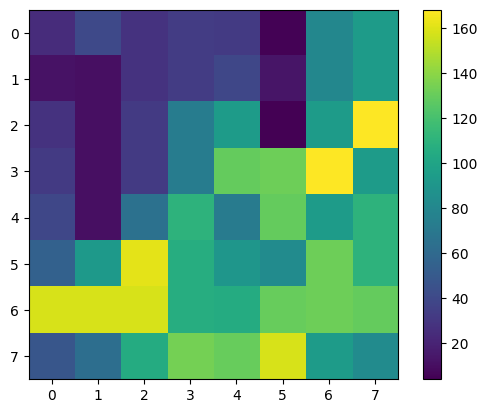

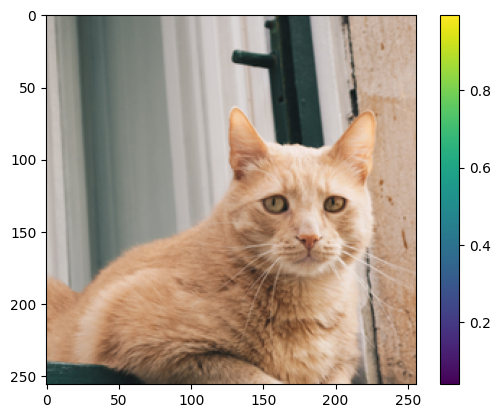

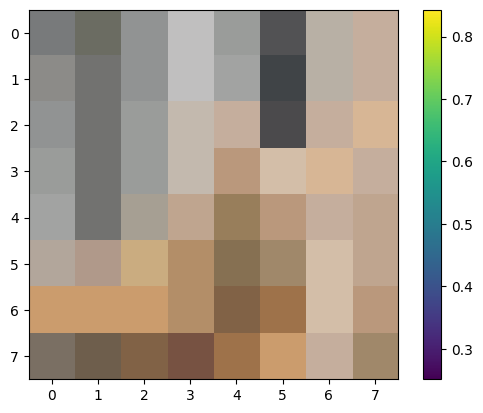

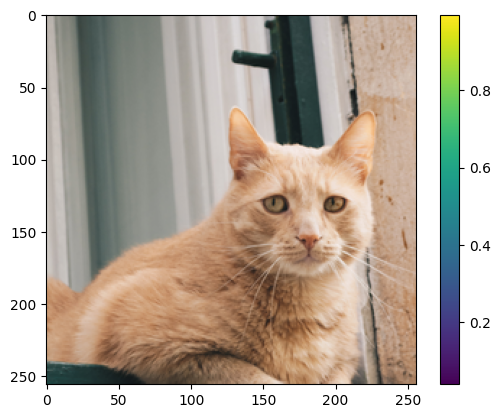

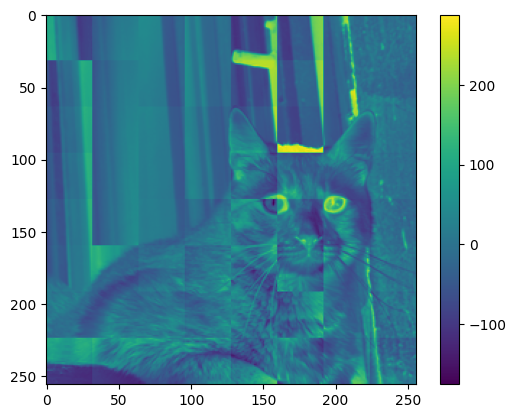

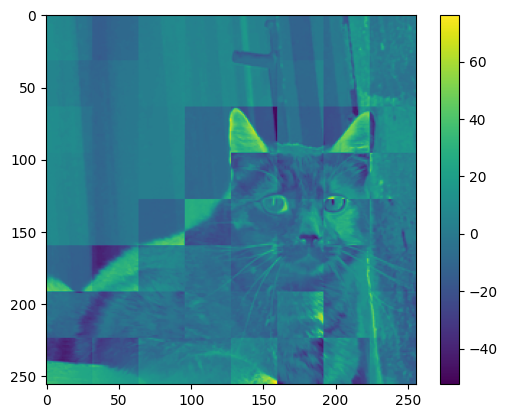

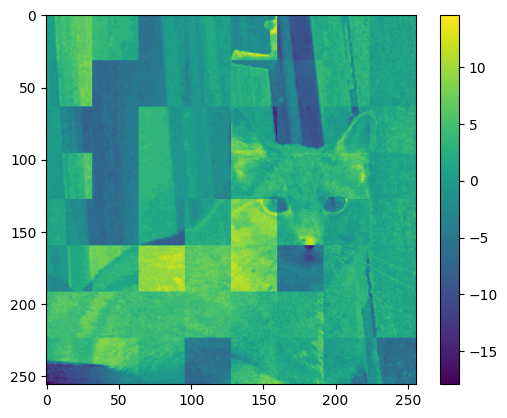

eng init [30454.16487121582, 23634.417022705078, 18919.33673095703]
PQR  256 31.33422054979019
eng remove mean [2825.1826515197754, 1989.5818939208984, 1879.3905639648438]
eng transform [5986.409616323356, 670.8620263207672, 36.88346676142488]
5986.40961632333
670.862026320762
36.883466761424515
10.0 10.0 254.0 254.0
1.368591497547495e-28


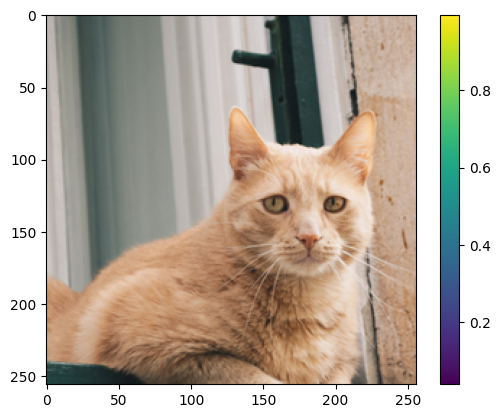

[[[[156.9 146.5 130.8]]]]


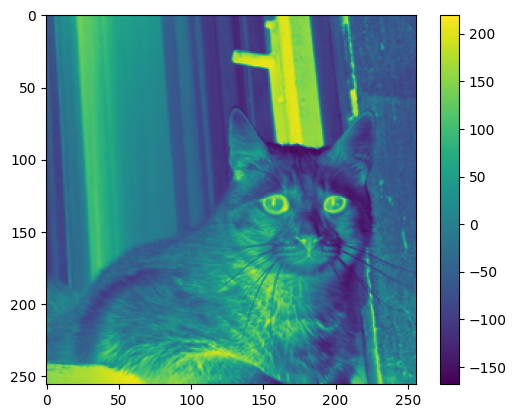

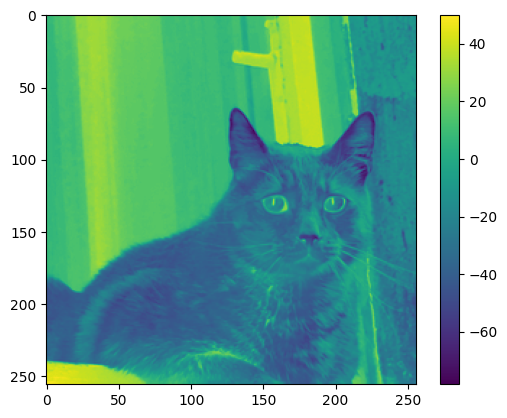

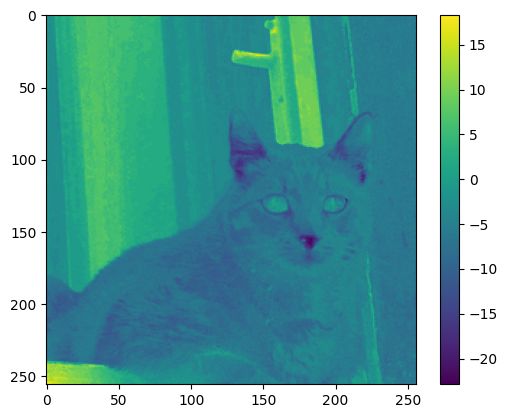

In [25]:
# %matplotlib auto
i=1
label, tX = pqr32.transform(It[i:i+1])
im = pqr32.colorM.inverse_predict(label)
X = pqr32.inverse_transform(label, tX)
for k in range(3):
    print(np.mean(np.square(tX[0,:,:,k])))
print(np.mean(np.square(X[0]-It[[i]])))

print(label)
plt.imshow(label[0,:,:,0])
plt.colorbar()
plt.show()
plt.imshow(It[i].astype('float')/255)
plt.colorbar()
plt.show()
plt.imshow(im[0].astype('float')/255)
plt.colorbar()
plt.show()
plt.imshow(X[0].astype('float')/255)
plt.colorbar()
plt.show()

plt.imshow(tX[0,:,:,0])
plt.colorbar()
plt.show()
plt.imshow(tX[0,:,:,1])
plt.colorbar()
plt.show()
plt.imshow(tX[0,:,:,2])
plt.colorbar()
plt.show()

m, tX1 = pqr256.transform(It[i:i+1]) 
im = pqr256.colorM.inverse_predict(m)
X = pqr256.inverse_transform(m, tX1)
for k in range(3):
    print(np.mean(np.square(tX1[0,:,:,k])))
print(np.min(X),np.min(It[i]), np.max(X), np.max(It[i]))
print(np.mean(np.square(X[0]-It[[i]])))
plt.imshow(X[0].astype('float')/255)
plt.colorbar()
plt.show()
print(im)
plt.imshow(tX1[0,:,:,0])
plt.colorbar()
plt.show()
plt.imshow(tX1[0,:,:,1])
plt.colorbar()
plt.show()
plt.imshow(tX1[0,:,:,2])
plt.colorbar()
plt.show()

In [9]:
from core.util.Huffman import *
def sVQ(X, Xt, n_codewords, win):
    X, Xt = Shrink(X, win), Shrink(Xt, win)
    km = myKMeans(256).fit(X)
    label = km.predict(X)
    labelt = km.predict(Xt)
    h = Huffman().fit(label)
    st, stt = h.encode(label), h.encode(labelt)
    iX, iXt = km.inverse_predict(label), km.inverse_predict(labelt)
    print(len(st), len(stt))
    return invShrink(iX, win), invShrink(iXt, win)

pqr32 = PQR(32).fit(I)
pqr256 = PQR(256).fit(I)
label32, X32 = pqr32.transform(I)
label256, X256 = pqr256.transform(I)  
label32t, X32t = pqr32.transform(It)
label256t, X256t = pqr256.transform(It)  
h32 = Huffman().fit(label32)
print('label',len(h32.encode(label32)), len(h32.encode(label32t)))
iX32, iX32t = sVQ(X32, X32t, 256, 4)
iI32, iI32t = pqr32.inverse_transform(label32, iX32), pqr32.inverse_transform(label32t, iX32t)
print('mse', np.mean(np.square(I-iI32)), np.mean(np.square(It-iI32t)))

h256 = Huffman().fit(label256)
print('label',len(h32.encode(label256)), len(h32.encode(label256t)))
iX256, iX256t = sVQ(X256, X256t, 256, 4)
iI256, iI256t = pqr256.inverse_transform(label256, iX256), pqr256.inverse_transform(label256t, iX256t)
print('mse', np.mean(np.square(I-iI256)), np.mean(np.square(It-iI256t)))



PQR  32 31.10927392772441


WARNING clustering 1427 points to 256 centroids: please provide at least 9984 training points


PQR  256 16.30215918562344
eng init [20150.594370338746, 19559.690159317157, 19182.324166429567]
PQR  32 31.10927392772441
eng remove mean [1324.440338599824, 1171.8875711374794, 1085.01561656989]
eng transform [3314.2914310389124, 206.59558909553752, 60.45650619762798]
eng init [20150.594370338746, 19559.690159317157, 19182.324166429567]
PQR  256 16.30215918562344
eng remove mean [3529.624081004393, 3314.8335049605153, 3240.928861781109]
eng transform [9443.73029911829, 565.9949731308583, 75.66117548530474]
eng init [22413.597091920914, 20020.83438258017, 18955.633553043488]
PQR  32 46.93794224841193
eng remove mean [1617.5818423615988, 1352.5252541181862, 1318.3799173319212]
eng transform [3780.4786756847957, 392.1672286348887, 115.84110947164615]
eng init [22413.597091920914, 20020.83438258017, 18955.633553043488]
PQR  256 35.148287650858684
eng remove mean [3548.4861389898483, 3503.6400307634826, 3166.4184725951122]
eng transform [9031.591970661537, 1025.5395052177025, 161.41316648

In [11]:
(93549)/186/256**2, (1482)/186/256**2

(0.007674432569934476, 0.00012157809349798387)

In [12]:
8*8*8/256**2

0.0078125

In [13]:
iI, iIt = sVQ(I, It, 256, 4)
print('mse', np.mean(np.square(I-iI)), np.mean(np.square(It-iIt)))


44646574 5898392
mse 226.60334823485476 299.4006435992246


In [19]:
712078/256**2/1427, 93549/256**2/186

(0.007614189206760249, 0.007674432569934476)

In [25]:
[58384,1420.971614-150,

457422,728.682774-150,

857084,388.381182]

[58384, 1270.971614, 457422, 578.682774, 857084, 388.381182]

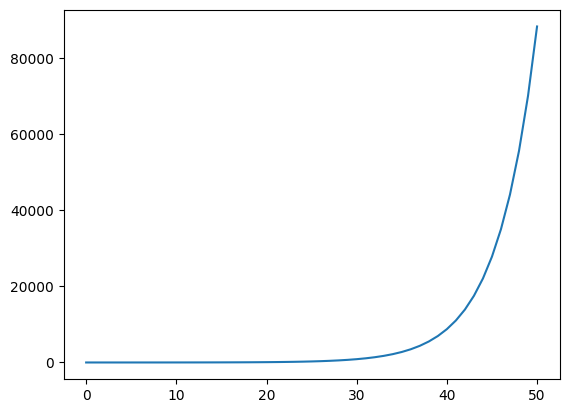

[8.5000000e-01 1.0710000e+00 1.3490000e+00 1.7000000e+00 2.1420000e+00
 2.6990000e+00 3.4000000e+00 4.2840000e+00 5.3970000e+00 6.8000000e+00
 8.5670000e+00 1.0794000e+01 1.3600000e+01 1.7135000e+01 2.1589000e+01
 2.7200000e+01 3.4270000e+01 4.3177000e+01 5.4400000e+01 6.8540000e+01
 8.6355000e+01 1.0880000e+02 1.3707900e+02 1.7270900e+02 2.1760000e+02
 2.7415900e+02 3.4541800e+02 4.3520000e+02 5.4831800e+02 6.9083700e+02
 8.7040000e+02 1.0966350e+03 1.3816740e+03 1.7408000e+03 2.1932710e+03
 2.7633480e+03 3.4816000e+03 4.3865410e+03 5.5266960e+03 6.9632000e+03
 8.7730820e+03 1.1053391e+04 1.3926400e+04 1.7546165e+04 2.2106782e+04
 2.7852800e+04 3.5092329e+04 4.4213564e+04 5.5705600e+04 7.0184658e+04
 8.8427128e+04]


In [32]:
a = np.arange(51)
def func(x):
    return 0.85*pow(2, x/3)#*1024**2
plt.plot(a, func(a))
plt.show()
print(np.round(func(a),decimals=3))

In [39]:
b = func(a)
ct = 0
for i in  b:
    print("%5.3f"%i, end=',')
    ct+=1
    if ct %6==0:
        print()

0.850,1.071,1.349,1.700,2.142,2.699,
3.400,4.284,5.397,6.800,8.567,10.794,
13.600,17.135,21.589,27.200,34.270,43.177,
54.400,68.540,86.355,108.800,137.079,172.709,
217.600,274.159,345.418,435.200,548.318,690.837,
870.400,1096.635,1381.674,1740.800,2193.271,2763.348,
3481.600,4386.541,5526.696,6963.200,8773.082,11053.391,
13926.400,17546.165,22106.782,27852.800,35092.329,44213.564,
55705.600,70184.658,88427.128,